# Libraries

In [1]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

# 🚫 Suppressing warnings 🚫
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [3]:
import os
from tqdm.auto import tqdm 
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count
import polars as pl
import random

# Load the data

In [4]:
df = pd.read_csv('/kaggle/input/colombian-frenchteam-problematicinternetusage/Dataset_problematic_internet_usage.csv')
len(df)

3960

In [5]:
df.groupby('Train_Test_Label').size()

Train_Test_Label
isnotintrainset    2964
test                200
train               796
dtype: int64

In [6]:
df = df[(df['Train_Test_Label']=='test') | (df['Train_Test_Label']=='train') ]
len(df)

996

In [7]:
df[df['sii']==3].head(3)

Unnamed: 0        id Basic_Demos-Enroll_Season  Basic_Demos-Age  \
894          894  35fa2ebf                    Summer               13   
1502        1502  5e55e9fd                    Spring               14   
2002        2002  7f44236f                      Fall               13   

      Basic_Demos-Sex CGAS-Season  CGAS-CGAS_Score Physical-Season  \
894                 0        Fall             70.0            Fall   
1502                1         NaN              NaN          Spring   
2002                0      Winter             70.0          Winter   

      Physical-BMI  Physical-Height  ...  PCIAT-PCIAT_20  PCIAT-PCIAT_Total  \
894      20.404192            61.00  ...             5.0               89.0   
1502     18.934295            60.75  ...             5.0               81.0   
2002     25.370016            67.00  ...             5.0               87.0   

      SDS-Season  SDS-SDS_Total_Raw  SDS-SDS_Total_T PreInt_EduHx-Season  \
894         Fall               37.0             53.0              Summer   
1502      Spring               44.0             62.0              Spring   
2002      Winter               47.0             66.0                Fall   

      PreInt_EduHx-computerinternet_hoursday  sii  Has_actigraphy_data  \
894                                      3.0  3.0                  Yes   
1502                                     3.0  3.0                  Yes   
2002                                     0.0  3.0                  Yes   

     Train_Test_Label  
894             train  
1502            train  
2002            train  

[3 rows x 85 columns]

In [8]:
df[df['sii']==0].head(3)

Unnamed: 0        id Basic_Demos-Enroll_Season  Basic_Demos-Age  \
22          22  01085eb3                      Fall               12   
25          25  012cadd8                    Spring                9   
26          26  012e3869                    Summer                6   

    Basic_Demos-Sex CGAS-Season  CGAS-CGAS_Score Physical-Season  \
22                0      Winter             58.0            Fall   
25                0      Winter             60.0            Fall   
26                0      Winter             60.0          Summer   

    Physical-BMI  Physical-Height  ...  PCIAT-PCIAT_20  PCIAT-PCIAT_Total  \
22     34.187282             60.5  ...             0.0               30.0   
25     17.089151             53.2  ...             0.0                9.0   
26           NaN              NaN  ...             0.0                0.0   

    SDS-Season  SDS-SDS_Total_Raw  SDS-SDS_Total_T PreInt_EduHx-Season  \
22        Fall               53.0             73.0                Fall   
25      Summer               27.0             40.0              Spring   
26         NaN                NaN              NaN              Summer   

    PreInt_EduHx-computerinternet_hoursday  sii  Has_actigraphy_data  \
22                                     0.0  0.0                  Yes   
25                                     0.0  0.0                  Yes   
26                                     0.0  0.0                  Yes   

   Train_Test_Label  
22            train  
25            train  
26            train  

[3 rows x 85 columns]

In [9]:
list_of_kids = df['id'].unique() #df[df['sii']==3].head(3)
list_of_kids[:10]

array(['00115b9f', '001f3379', '00f332d1', '01085eb3', '012cadd8',
       '012e3869', '029a19c9', '02cebf33', '02cf7384', '035c96dd'],
      dtype=object)

# Visualizing the available metrics in the actigraphy data v2

In [10]:
id='5e55e9fd'
#5e55e9fd has a little more days with enough wear percentage
#35fa2ebf only has like 4 days with enough wear percentage

train_series = (
        pl.scan_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
        .with_columns(
            (pl.col("time_of_day").cast(pl.Int64) / 1_000_000_000).alias("total_seconds")
        )
        .with_columns(
            [
                (pl.col("total_seconds") // 3600).alias("hour"),
                ((pl.col("total_seconds") % 3600) // 60).alias("minute"),
                (pl.col("total_seconds") % 60).alias("second"),
            ]
        )
        .collect()
        .to_pandas()
    )

train_series['time_of_day_hours'] = (train_series['time_of_day'] / 1e9 / 3600) #nanoseconds to hours
train_series['time_of_day_half_hours'] = (train_series['time_of_day'] / 1e9 / 900) #nanoseconds to half-hours
train_series['day_time'] = train_series['relative_date_PCIAT'] + (train_series['time_of_day_hours'] / 24)
train_series['day_time']

day_start_hour = 8
day_end_hour = 21

train_series['day_period'] = np.where(
    (train_series['time_of_day_hours'] >= day_start_hour) &
    (train_series['time_of_day_hours'] < day_end_hour),
    'day', 'night'
)

# Initialize the first day
train_series['which_day'] = 0

# Create a mask to identify changes in day
day_change = (
        (train_series['weekday'] != train_series['weekday'].shift(1)) |
        (train_series['hour'] < train_series['hour'].shift(1)) |
        ((train_series['hour'] == train_series['hour'].shift(1)) & (train_series['minute'] < train_series['minute'].shift(1))) |
        ((train_series['hour'] == train_series['hour'].shift(1)) & (train_series['minute'] == train_series['minute'].shift(1)) & (train_series['second'] < train_series['second'].shift(1)))
    )

# Use cumsum to create a cumulative sum that increments for each change
train_series['which_day'] = day_change.cumsum() + 1

train_series['day_period_b']=np.where(train_series['day_period']=='day',1,0)

In [11]:
train_series.head(3)

step         X         Y         Z      enmo     anglez  non-wear_flag  \
0     0 -0.539155 -0.088242 -0.405438  0.110990 -23.162010            0.0   
1     1  0.290533  0.115993 -0.719374  0.054107 -50.736881            0.0   
2     2  0.460053  0.125667 -0.749758  0.026650 -56.019619            0.0   

   light  battery_voltage     time_of_day  ...  total_seconds  hour  minute  \
0    9.0      4188.000000  55800000000000  ...        55800.0  15.0    30.0   
1    0.0      4187.583496  55805000000000  ...        55805.0  15.0    30.0   
2    5.0      4187.166504  55810000000000  ...        55810.0  15.0    30.0   

   second  time_of_day_hours  time_of_day_half_hours   day_time  day_period  \
0     0.0          15.500000               62.000000  12.645833         day   
1     5.0          15.501389               62.005556  12.645891         day   
2    10.0          15.502778               62.011111  12.645949         day   

   which_day  day_period_b  
0          2             1  
1          2             1  
2          2             1  

[3 rows x 23 columns]

## Plotting all days of data for a given id, with the 5 seconds intervals

In [12]:
def plot_series_data(df, col='non-wear_flag',
                     label='Worn (0 = Worn, 1 = Not Worn)',
                     title='Non-Wear Flag',
                     x_col='day_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 12))
    
    # ENMO
    plt.subplot(4, 1, 1)
    plt.scatter(df[x_col], df['enmo'], label='ENMO', color='green', s=1)
    plt.fill_between(df[x_col],df['enmo'].min(), df['enmo'].max(),where=(df['day_period'] == 'day'),color='blue', alpha=0.1, label='Day Period')
    plt.title('ENMO (Euclidean Norm Minus One)')
    plt.ylabel('Movement Intensity')

    # Angle Z
    plt.subplot(4, 1, 2)
    plt.scatter(df[x_col], df['anglez'], label='Angle Z', color='blue', s=1)
    plt.fill_between(df[x_col],df['anglez'].min(), df['anglez'].max(),where=(df['day_period'] == 'day'),color='blue', alpha=0.1, label='Day Period')
    plt.title('Angle Z')
    plt.ylabel('Angle (degrees)')

    # Light
    plt.subplot(4, 1, 3)
    plt.scatter(df[x_col], df['light'], label='Light', color='orange', s=1)
    plt.fill_between(df[x_col],df['light'].min(), df['light'].max(),where=(df['day_period'] == 'day'),color='blue', alpha=0.1, label='Day Period')
    plt.title('Ambient Light')
    plt.ylabel('Light (lux)')

    # Any other column
    plt.subplot(4, 1, 4)
    plt.scatter(df[x_col], df[col], label=col, color='red', s=1)
    plt.fill_between(df[x_col],df[col].min(), df[col].max(),where=(df['day_period'] == 'day'),color='blue', alpha=0.1, label='Day Period')
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.xlabel(f'{x_label}')

    plt.tight_layout()
    plt.show()

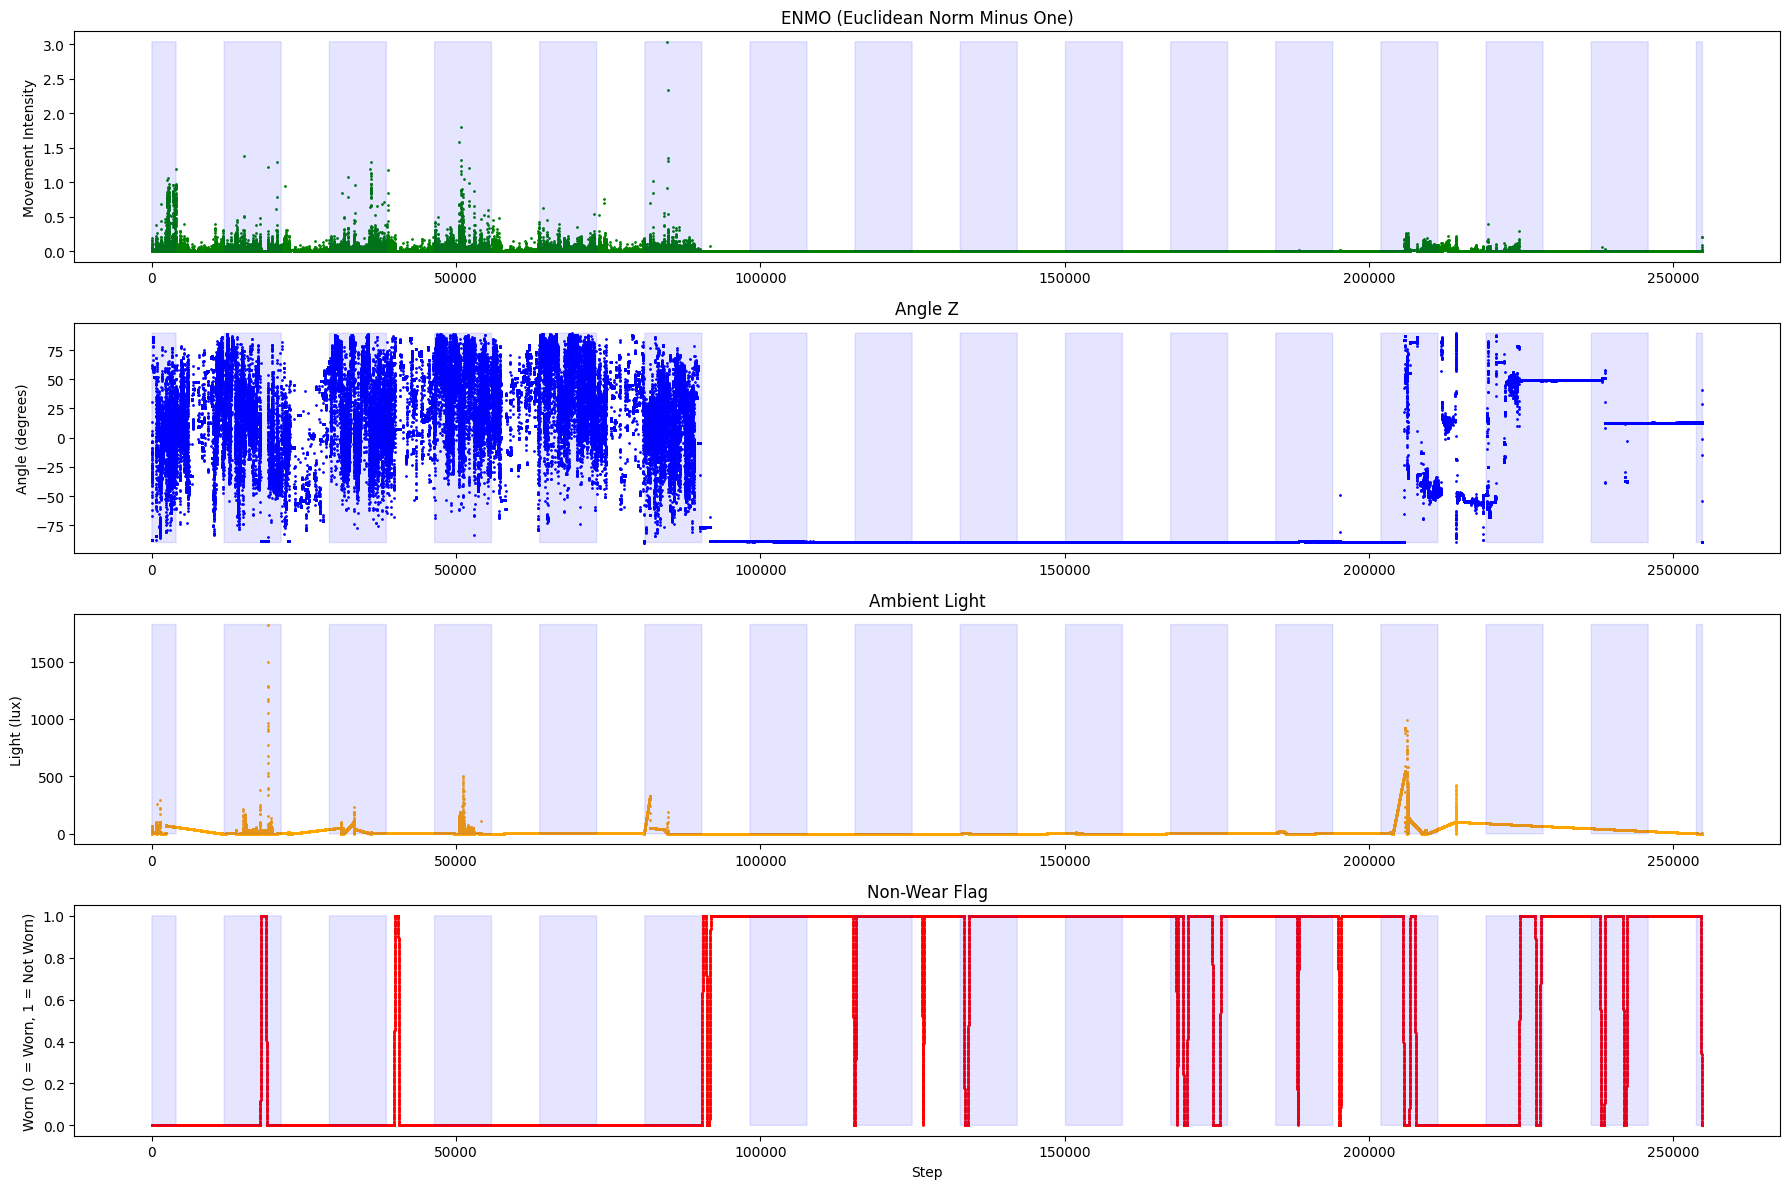

In [13]:
plot_series_data(train_series, x_col='step', x_label='Step')

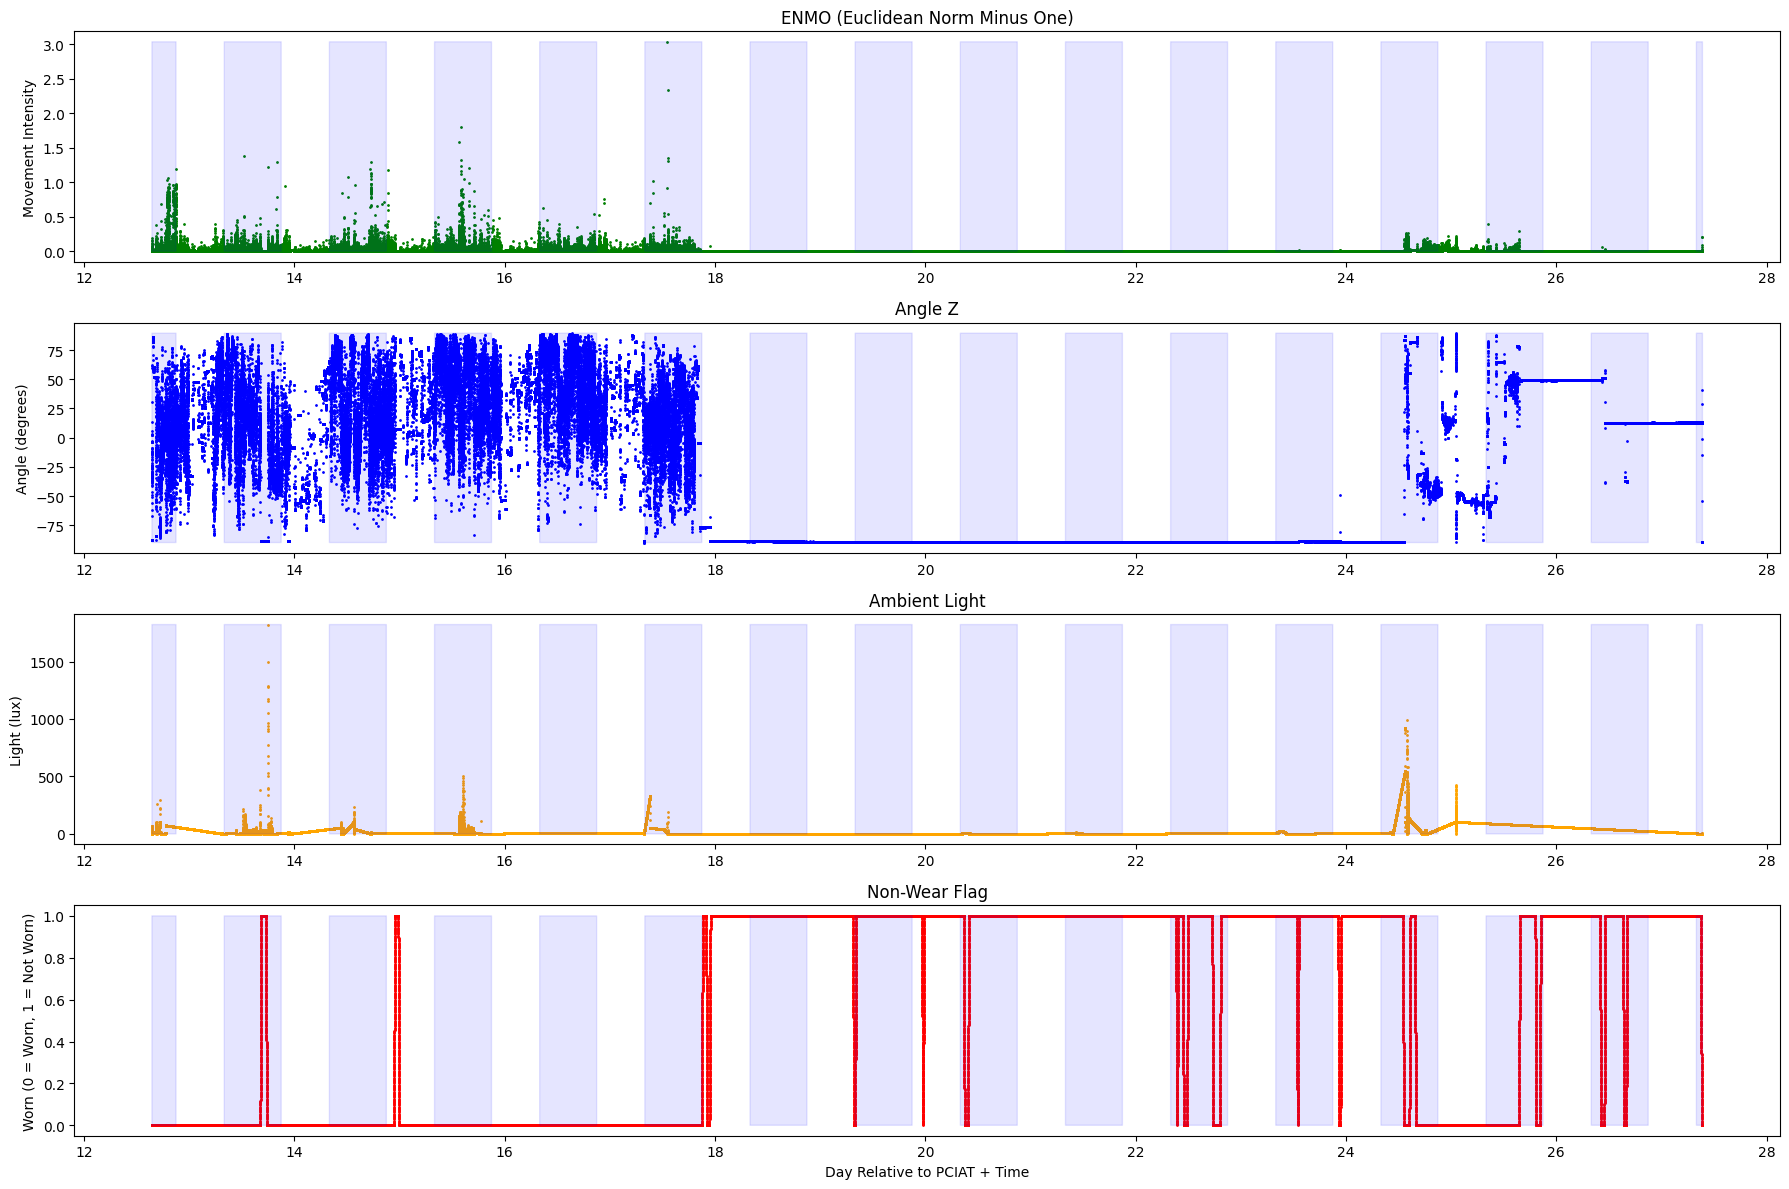

In [14]:
plot_series_data(train_series, x_col='day_time', x_label='Day Relative to PCIAT + Time')

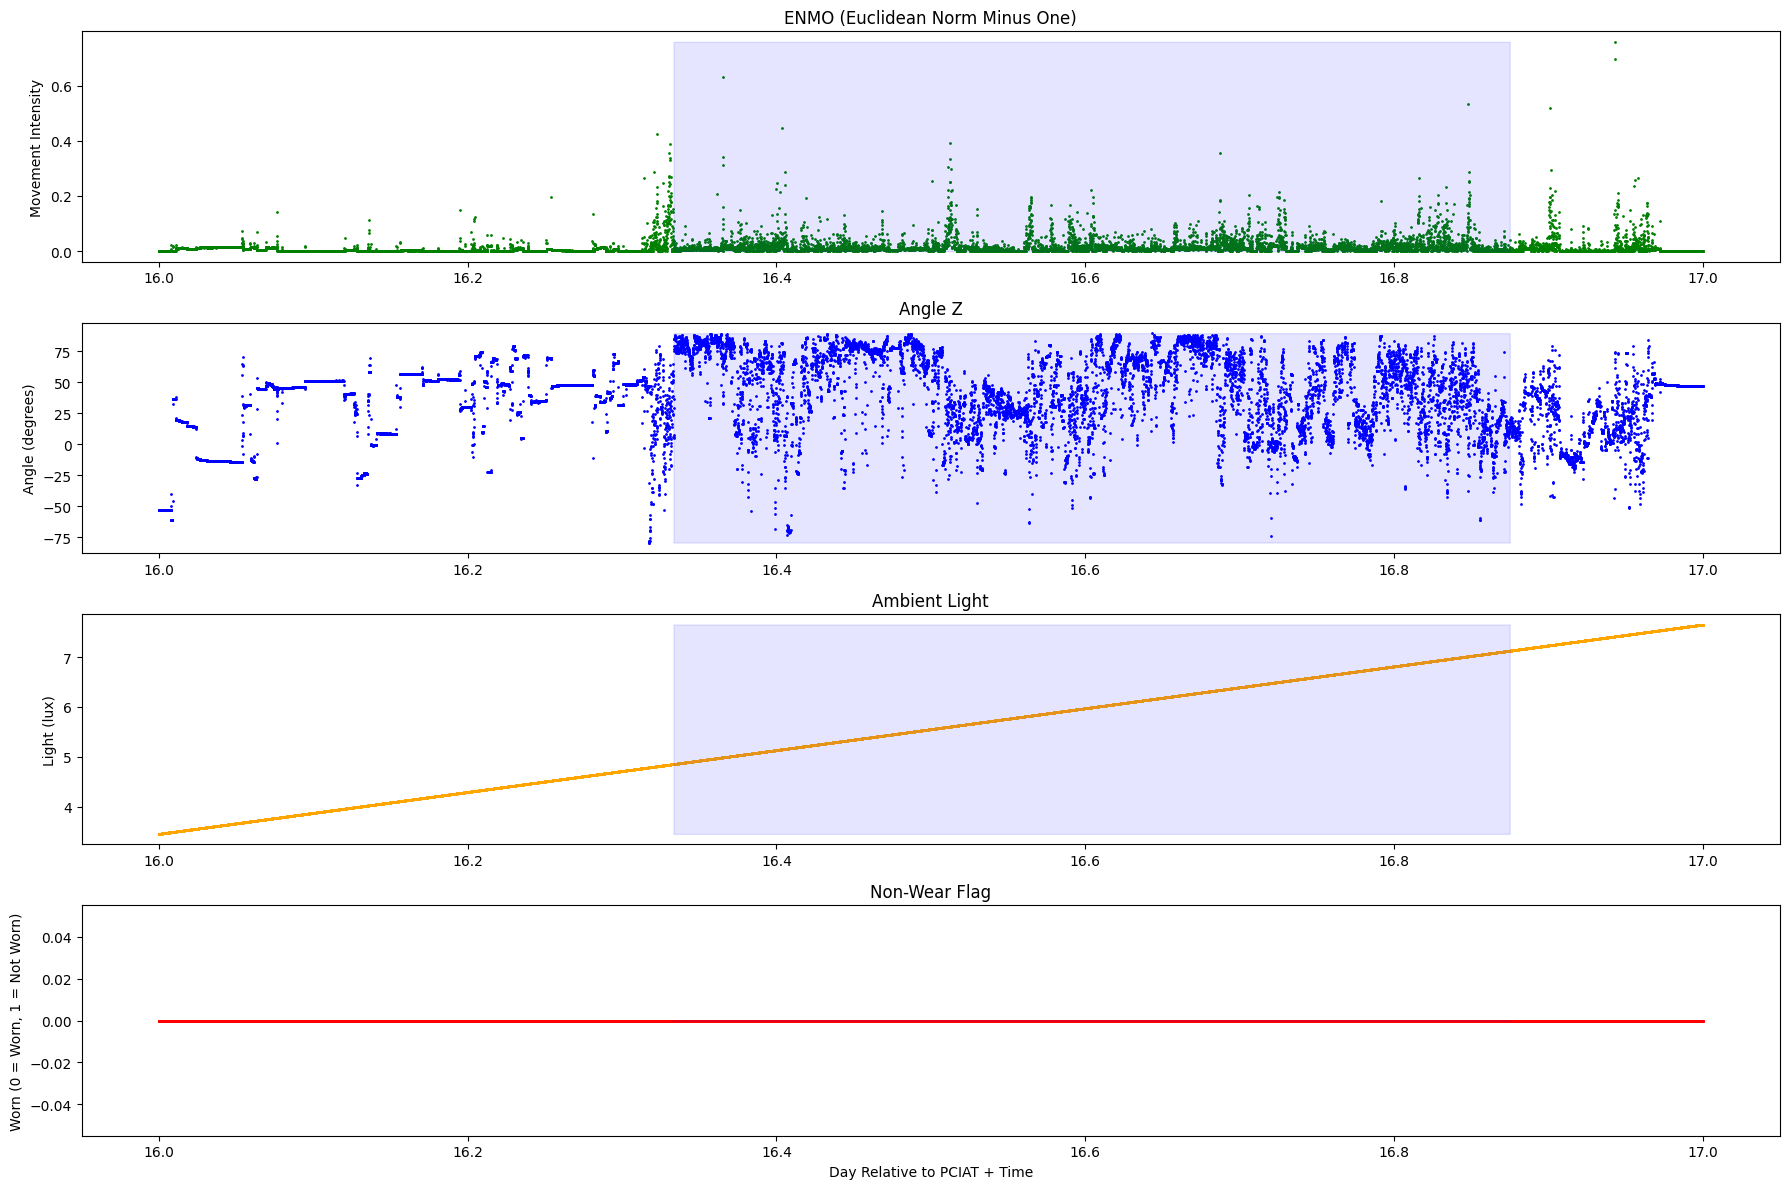

In [15]:
start_day = 5 # second day of wearing the device
show_days = 1

first_day = min(train_series['relative_date_PCIAT']) + start_day - 1
filtered_data = train_series[
    (train_series['relative_date_PCIAT'] >= first_day) &
    (train_series['relative_date_PCIAT'] <= first_day + show_days - 1)
].copy()

plot_series_data(filtered_data)

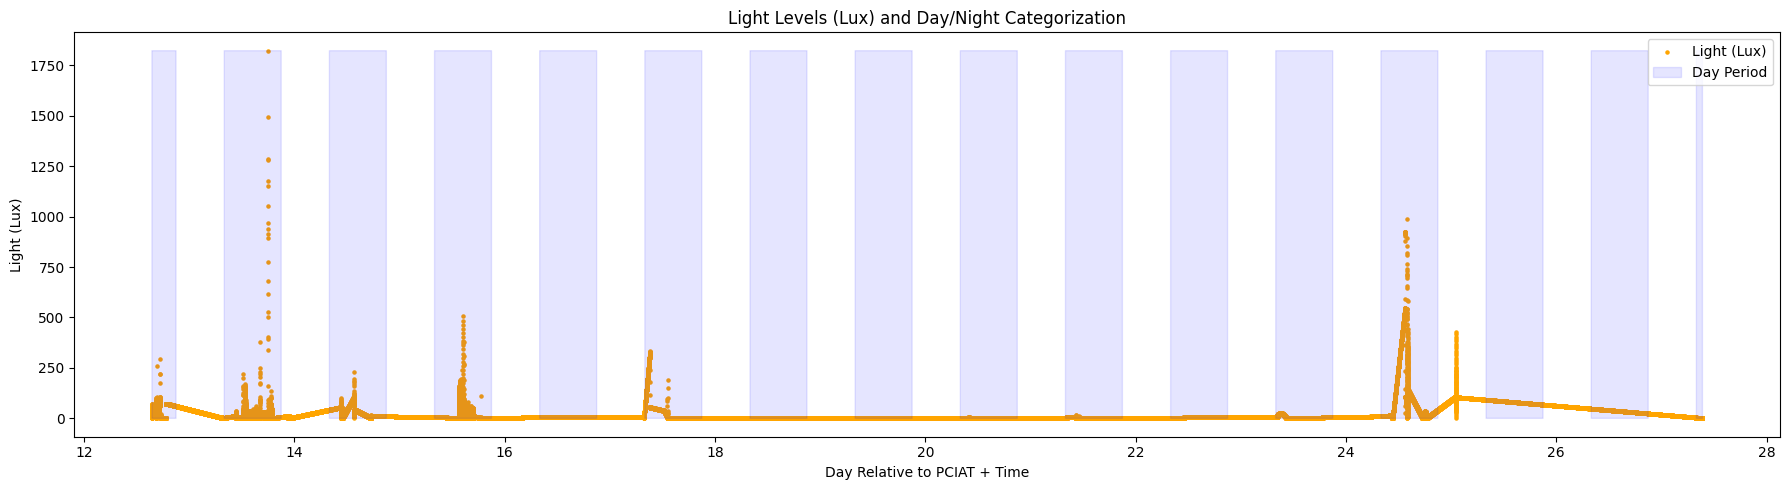

In [16]:
plt.figure(figsize=(18, 5))

plt.scatter(train_series['day_time'], train_series['light'], label='Light (Lux)', 
         color='orange', s=5)

plt.fill_between(train_series['day_time'],
                 0, train_series['light'].max(),
                 where=(train_series['day_period'] == 'day'),
                 color='blue', alpha=0.1, label='Day Period')

plt.title('Light Levels (Lux) and Day/Night Categorization')
plt.ylabel('Light (Lux)')
plt.xlabel('Day Relative to PCIAT + Time')
plt.legend()

plt.tight_layout()
plt.show()

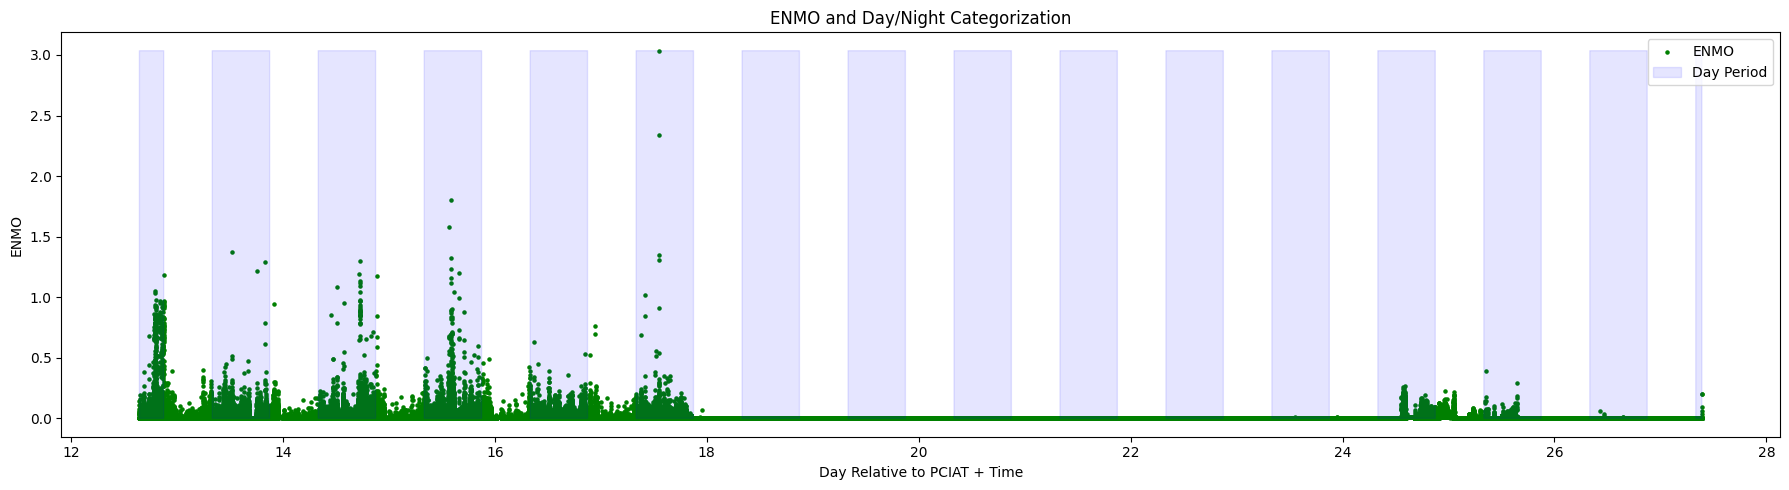

In [17]:
plt.figure(figsize=(18, 5))

plt.scatter(train_series['day_time'], train_series['enmo'], label='ENMO', 
         color='Green', s=5)

plt.fill_between(train_series['day_time'],
                 0, train_series['enmo'].max(),
                 where=(train_series['day_period'] == 'day'),
                 color='blue', alpha=0.1, label='Day Period')

plt.title('ENMO and Day/Night Categorization')
plt.ylabel('ENMO')
plt.xlabel('Day Relative to PCIAT + Time')
plt.legend()

plt.tight_layout()
plt.show()

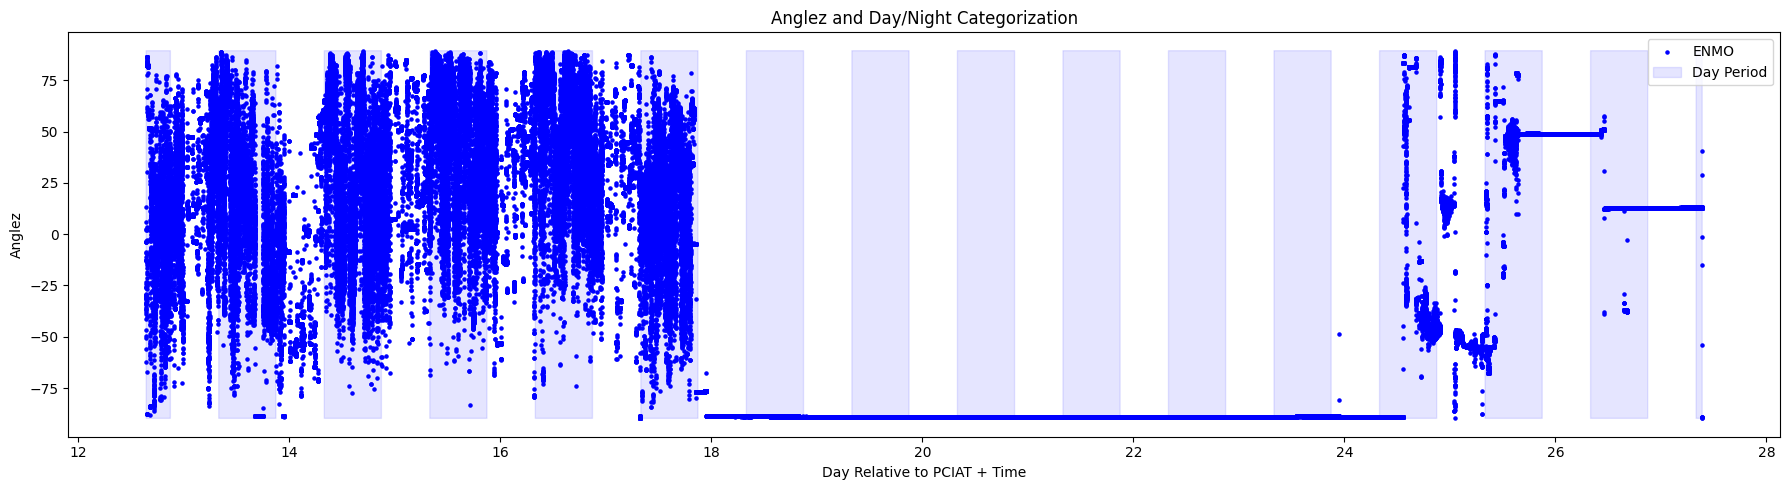

In [18]:
plt.figure(figsize=(18, 5))

plt.scatter(train_series['day_time'], train_series['anglez'], label='ENMO', 
         color='Blue', s=5)

plt.fill_between(train_series['day_time'],
                 train_series['anglez'].min(), train_series['anglez'].max(),
                 where=(train_series['day_period'] == 'day'),
                 color='blue', alpha=0.1, label='Day Period')

plt.title('Anglez and Day/Night Categorization')
plt.ylabel('Anglez')
plt.xlabel('Day Relative to PCIAT + Time')
plt.legend()

plt.tight_layout()
plt.show()

# Maybe we can try plotting but instead of all points, just plot the hourly average

## mean every hour

In [19]:
def plot_series_data_mean_values(df, col='non_wear_flag',
                     label='Worn (0 = Worn, 1 = Not Worn)',
                     title='Non-Wear Flag',
                     x_col='continuous_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 12))
    
    df2 = df.groupby(['which_day', df['time_of_day_hours'].astype(int)]).agg(
        enmo=('enmo', 'mean'), 
        anglez=('anglez', 'mean'),
        light=('light', 'mean'),
        non_wear_flag=('non-wear_flag', 'mean'),
        day_period=('day_period_b', 'max'))
    
    df2 = df2.reset_index()
    df2['continuous_time'] = df2['which_day'] * 24 + df2['time_of_day_hours']
    
    # ENMO
    plt.subplot(4, 1, 1)
    plt.scatter(df2[x_col], df2['enmo'], label='ENMO', color='green', s=2)
    plt.fill_between(df2[x_col],df2['enmo'].min(), df2['enmo'].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title('ENMO (Euclidean Norm Minus One)')
    plt.ylabel('Movement Intensity')

    # Angle Z
    plt.subplot(4, 1, 2)
    plt.scatter(df2[x_col], df2['anglez'], label='Angle Z', color='blue', s=2)
    plt.fill_between(df2[x_col],df2['anglez'].min(), df2['anglez'].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title('Angle Z')
    plt.ylabel('Angle (degrees)')

    # Light
    plt.subplot(4, 1, 3)
    plt.scatter(df2[x_col], df2['light'], label='Light', color='orange', s=2)
    plt.fill_between(df2[x_col],df2['light'].min(), df2['light'].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title('Ambient Light')
    plt.ylabel('Light (lux)')

    # Any other column
    plt.subplot(4, 1, 4)
    plt.scatter(df2[x_col], df2[col], label=col, color='red', s=2)
    plt.fill_between(df2[x_col],df2[col].min(), df2[col].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.xlabel(f'{x_label}')

    plt.tight_layout()
    plt.show()

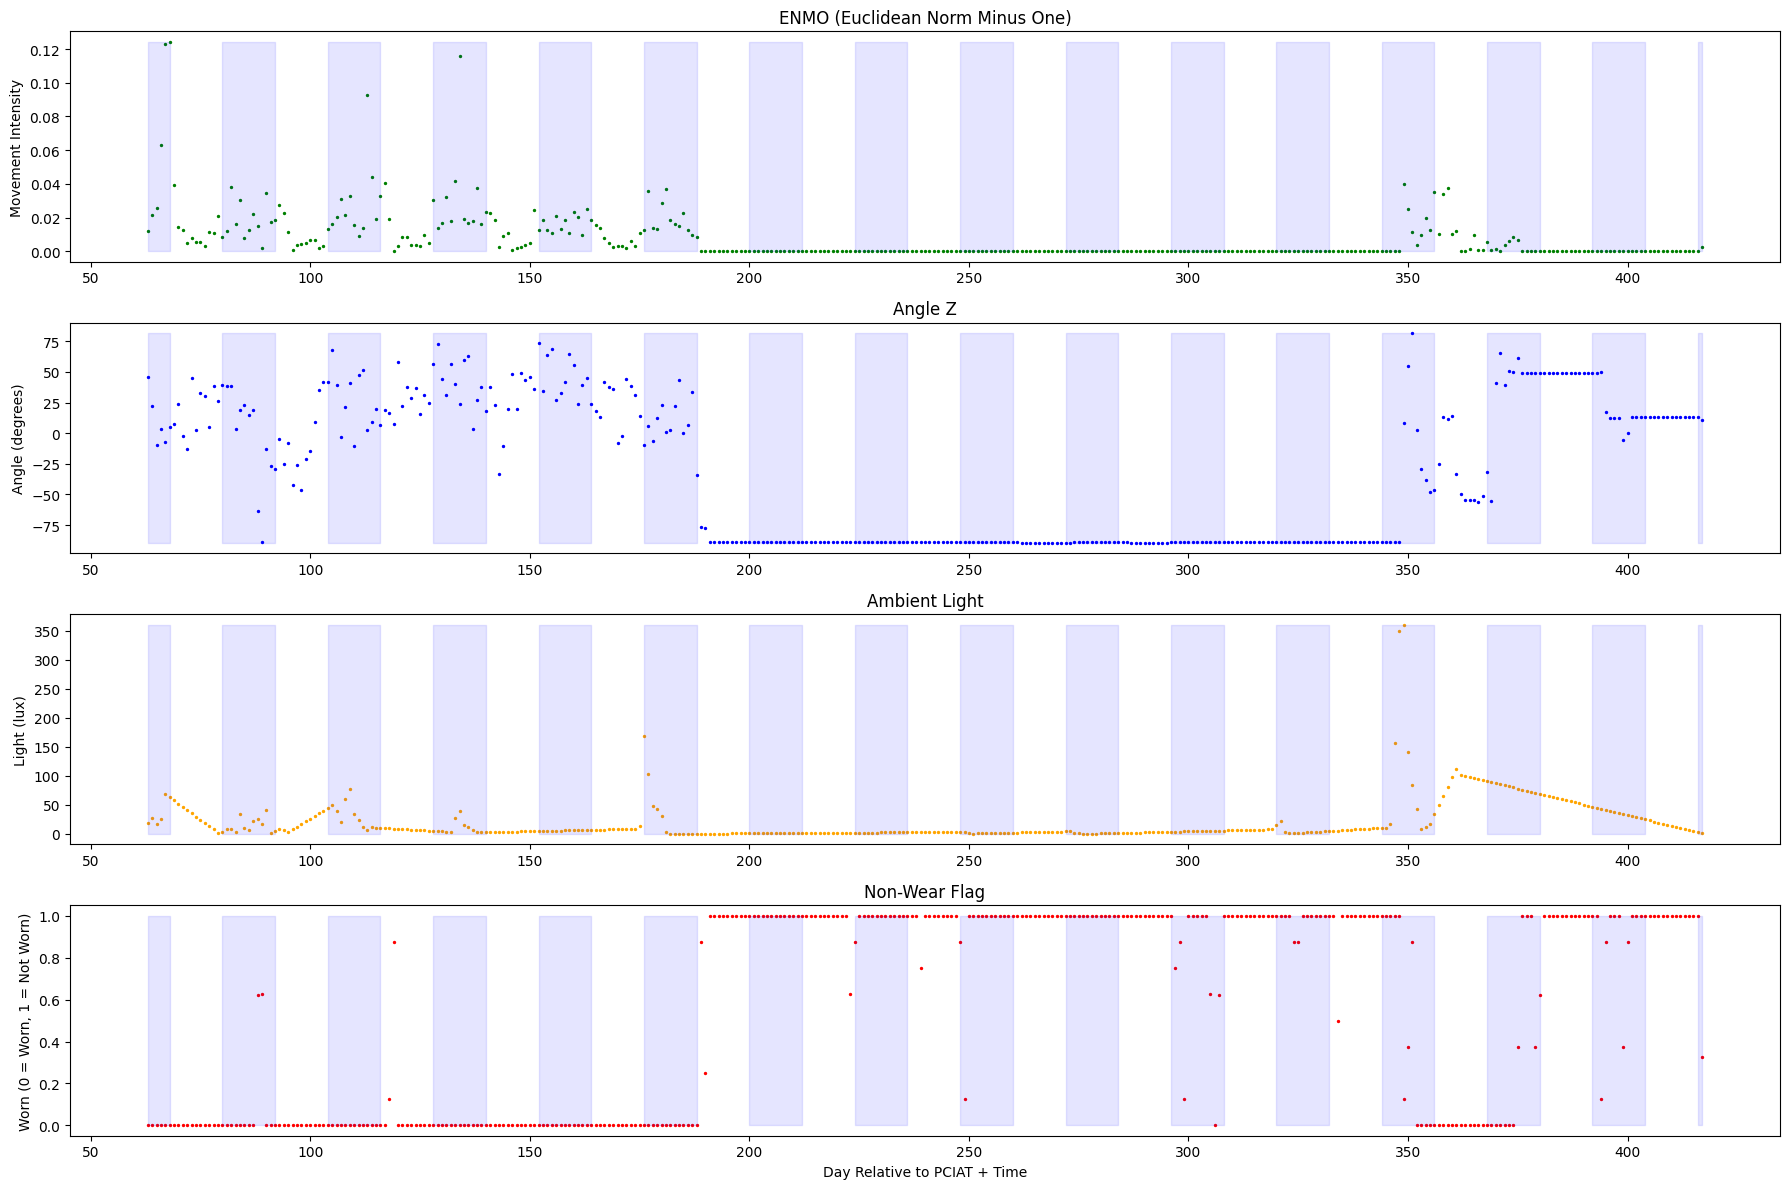

In [20]:
plot_series_data_mean_values(train_series)

## mean but every half and hour

In [21]:
def plot_series_data_mean_values(df, col='non_wear_flag',
                     label='Worn (0 = Worn, 1 = Not Worn)',
                     title='Non-Wear Flag',
                     x_col='continuous_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 12))
    
    df2 = df.groupby(['which_day', df['time_of_day_half_hours'].astype(int)]).agg(
        enmo=('enmo', 'mean'), 
        anglez=('anglez', 'mean'),
        light=('light', 'mean'),
        non_wear_flag=('non-wear_flag', 'mean'),
        day_period=('day_period_b', 'max'))
    
    df2 = df2.reset_index()
    df2['continuous_time'] = df2['which_day'] * 96 + df2['time_of_day_half_hours']
    
    # ENMO
    plt.subplot(4, 1, 1)
    plt.scatter(df2[x_col], df2['enmo'], label='ENMO', color='green', s=2)
    plt.fill_between(df2[x_col],df2['enmo'].min(), df2['enmo'].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title('ENMO (Euclidean Norm Minus One)')
    plt.ylabel('Movement Intensity')

    # Angle Z
    plt.subplot(4, 1, 2)
    plt.scatter(df2[x_col], df2['anglez'], label='Angle Z', color='blue', s=2)
    plt.fill_between(df2[x_col],df2['anglez'].min(), df2['anglez'].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title('Angle Z')
    plt.ylabel('Angle (degrees)')

    # Light
    plt.subplot(4, 1, 3)
    plt.scatter(df2[x_col], df2['light'], label='Light', color='orange', s=2)
    plt.fill_between(df2[x_col],df2['light'].min(), df2['light'].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title('Ambient Light')
    plt.ylabel('Light (lux)')

    # Any other column
    plt.subplot(4, 1, 4)
    plt.scatter(df2[x_col], df2[col], label=col, color='red', s=2)
    plt.fill_between(df2[x_col],df2[col].min(), df2[col].max(),where=(df2['day_period'] == 1),color='blue', alpha=0.1, label='Day Period')
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.xlabel(f'{x_label}')

    plt.tight_layout()
    plt.show()

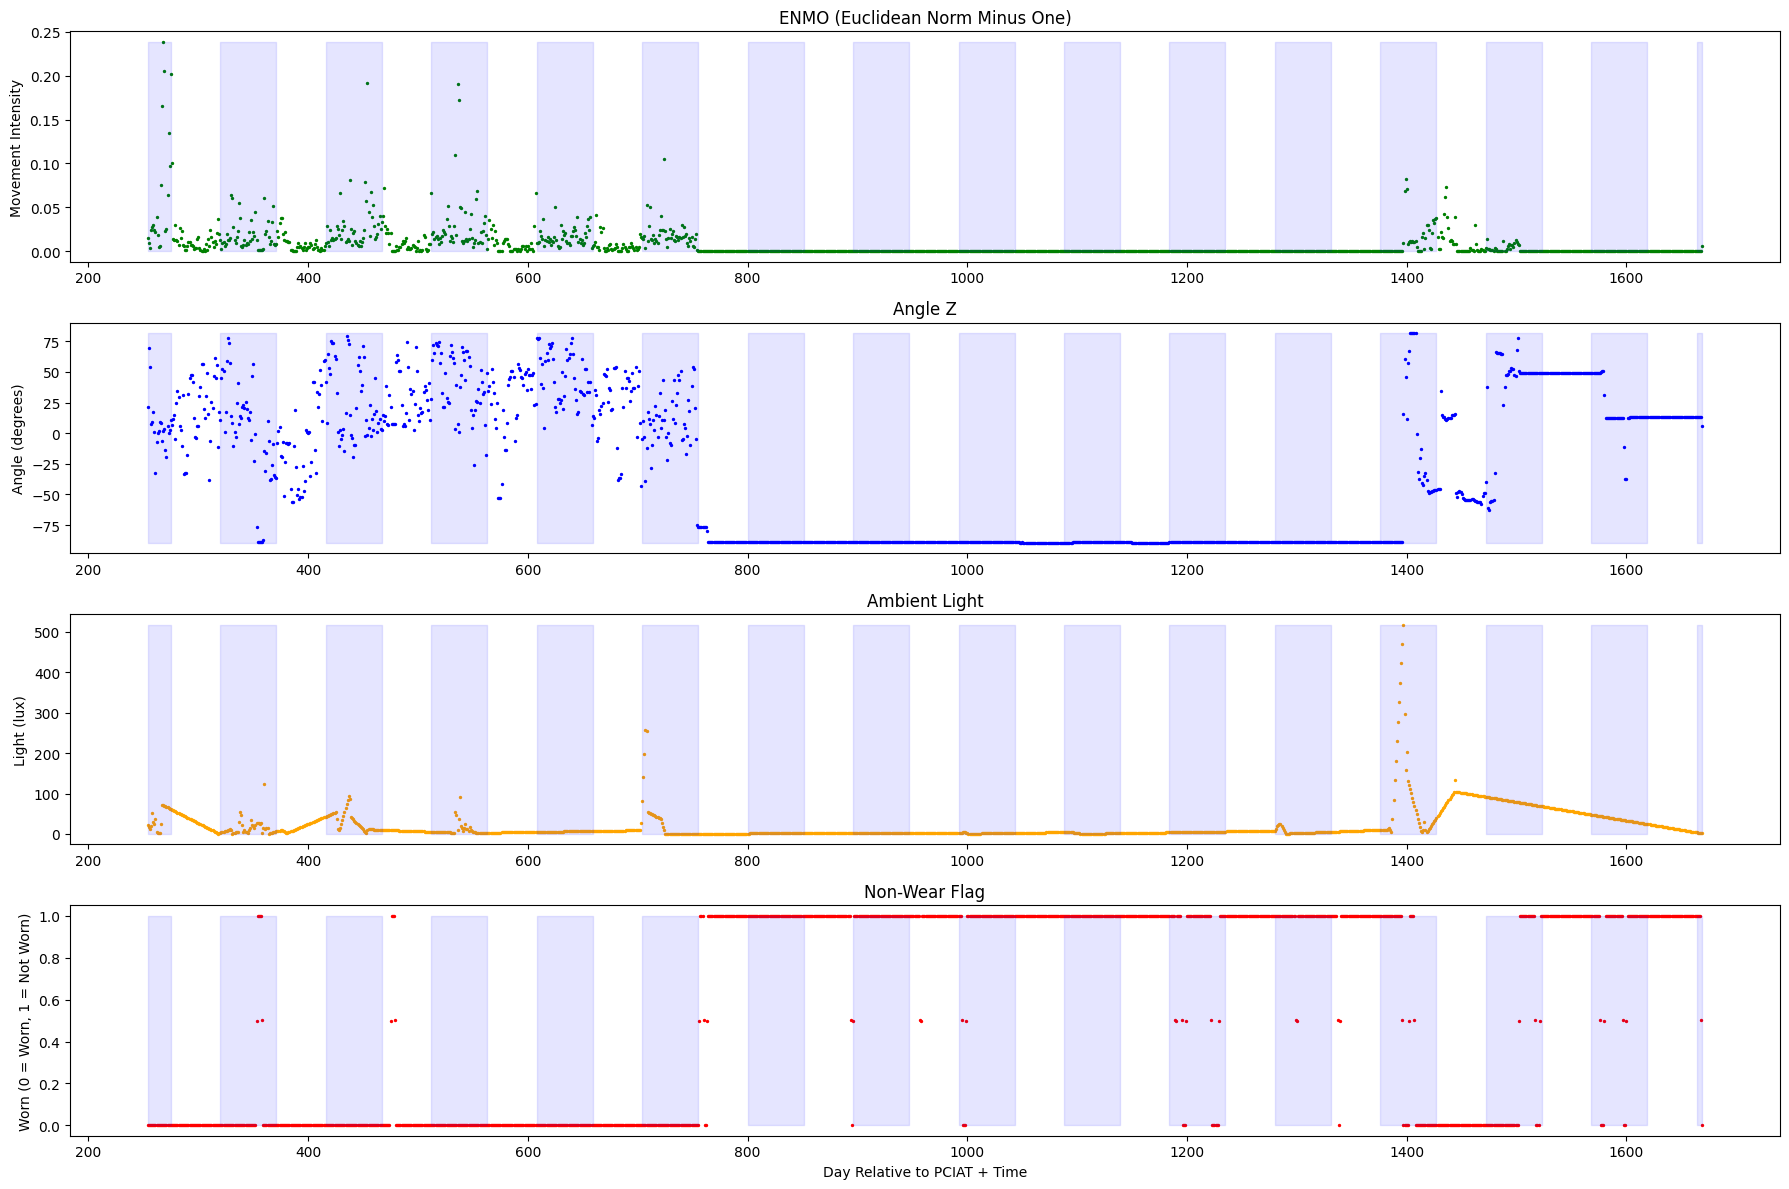

In [22]:
plot_series_data_mean_values(train_series)

# Joining all the plots in just one

In [40]:
from sklearn.preprocessing import MinMaxScaler

def plot_series_data_mean_values(df, col='non_wear_flag',
                                 label='Worn (0 = Worn, 1 = Not Worn)',
                                 title='Non-Wear Flag',
                                 x_col='continuous_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 3))
    
    # Grouping the data and calculating mean values for each column
    df2 = df.groupby(['which_day', df['time_of_day_half_hours'].astype(int)]).agg(
        enmo=('enmo', 'mean'), 
        anglez=('anglez', 'mean'),
        light=('light', 'mean'),
        non_wear_flag=('non-wear_flag', 'mean'),
        day_period=('day_period_b', 'max'))
    
    df2 = df2.reset_index()
    df2['continuous_time'] = df2['which_day'] * 96 + df2['time_of_day_half_hours']
    
    # Normalize the columns to be between 0 and 1
    df2['enmo'] = (df2['enmo'] - df2['enmo'].min()) / (df2['enmo'].max() - df2['enmo'].min())
    df2['anglez'] = (df2['anglez'] - df2['anglez'].min()) / (df2['anglez'].max() - df2['anglez'].min())
    df2['light'] = (df2['light'] - df2['light'].min()) / (df2['light'].max() - df2['light'].min())
    df2['non_wear_flag'] = (df2['non_wear_flag'] - df2['non_wear_flag'].min()) / (df2['non_wear_flag'].max() - df2['non_wear_flag'].min())
    
    # Plotting all the metrics in one plot
    
    # ENMO
    plt.scatter(df2[x_col], df2['enmo'], label='ENMO', color='green', alpha=0.7, s=10)
    #plt.plot(df2[x_col], df2['enmo'], label='ENMO', color='green', alpha=0.7, linestyle='-', marker='o', markersize=2)
    
    # Angle Z
    plt.scatter(df2[x_col], df2['anglez'], label='Angle Z', color='blue', alpha=0.7, s=10)
    #plt.plot(df2[x_col], df2['anglez'], label='Angle Z', color='blue', alpha=0.7, linestyle='-', marker='x', markersize=2)
    
    # Light
    plt.scatter(df2[x_col], df2['light'], label='Light', color='orange', alpha=0.7, s=5)
    
    # Non-Wear Flag (your custom column)
    plt.scatter(df2[x_col], df2[col], label=col, color='red', alpha=0.7, s=5)
    
    # Fill the day period with different color based on the max_day_period
    plt.fill_between(df2[x_col], 0, 1, where=(df2['day_period'] == 1), color='blue', alpha=0.1, label='Day Period')
    
    # Adding labels and title
    plt.title(f'{title}')
    plt.xlabel(f'{x_label}')
    plt.ylabel('Normalized Values')
    
    # Optional: Add grid for better readability
    plt.grid(True)
    
    # Adjust layout to make sure nothing is clipped
    plt.tight_layout()
    
    # Show the plot
    plt.show()

### Reminders
* enmo is depicted at green, the theory is that higher values of enmo --> movement
* anglez deviates more when there is movement, when the kid sleeps, it does not change that big
* Non-Wear Flag is 1 when the watch is not worn -  0 if it is 
* light exposure speaks by itself, but interestingly it seems is was manually calculated. its behabitor seems strange. 

* I added a fill_between to mark with purple the periods, where is between 8am and 9pm this super arbitrary, but we could say that the inappropiate internet usage could be identified but late night activity

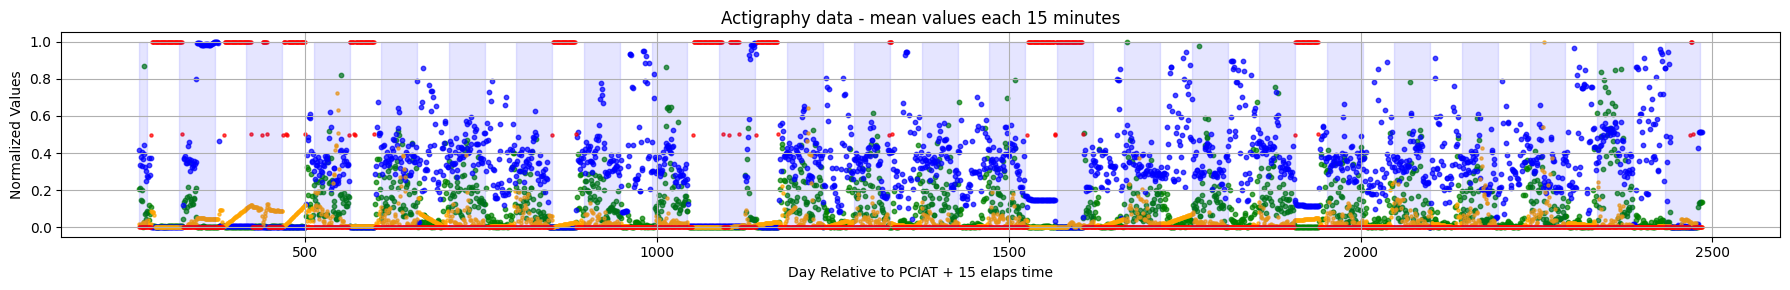

In [41]:
plot_series_data_mean_values(train_series, title='Actigraphy data - mean values each 15 minutes', x_label='Day Relative to PCIAT + 15 elaps time')

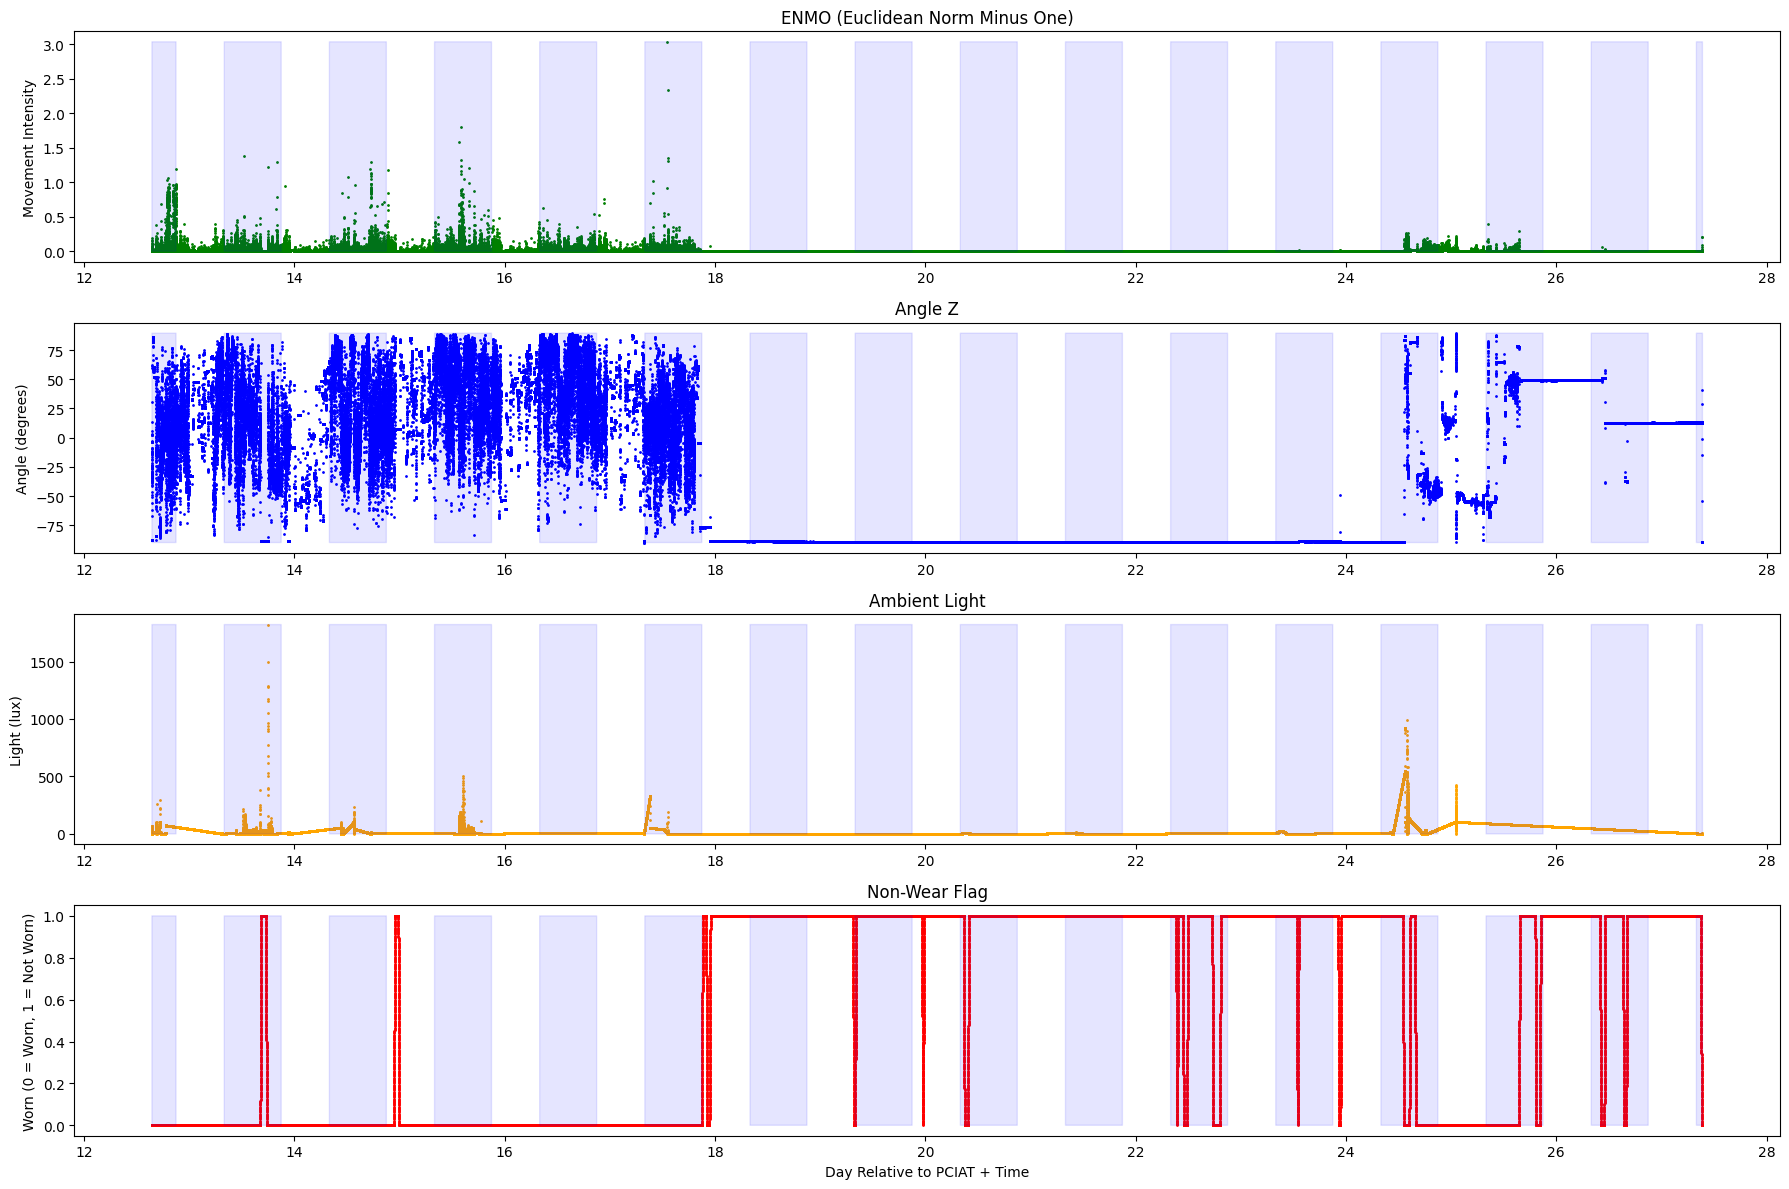

In [25]:
plot_series_data(train_series, x_col='day_time', x_label='Day Relative to PCIAT + Time')

# Plot 30 kids randomly out of the 996, to see their image.. lets try it out :)

In [42]:
# Function to plot the data for each selected ID
def plot_series_data_for_kid(kid_id, train_series, sii_value, title, x_label):
    # Modify the title to include the kid's ID and sii value
    plot_title = f"{title} - Kid ID: {kid_id}, SII: {sii_value}"
    
    # Call the plotting function with the updated title
    plot_series_data_mean_values(train_series, title=plot_title, x_label=x_label)


In [43]:
def process_actigraphy_files(kid_id):
    
    train_series = (
        pl.scan_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={kid_id}/part-0.parquet')
        .with_columns(
            (pl.col("time_of_day").cast(pl.Int64) / 1_000_000_000).alias("total_seconds")
        )
        .with_columns(
            [
                (pl.col("total_seconds") // 3600).alias("hour"),
                ((pl.col("total_seconds") % 3600) // 60).alias("minute"),
                (pl.col("total_seconds") % 60).alias("second"),
            ]
        )
        .collect()
        .to_pandas()
    )

    # Additional columns and preprocessing
    train_series['time_of_day_hours'] = (train_series['time_of_day'] / 1e9 / 3600)  # nanoseconds to hours
    train_series['time_of_day_half_hours'] = (train_series['time_of_day'] / 1e9 / 900)  # nanoseconds to half-hours
    train_series['day_time'] = train_series['relative_date_PCIAT'] + (train_series['time_of_day_hours'] / 24)

    # Day period assignment
    day_start_hour = 8
    day_end_hour = 21
    train_series['day_period'] = np.where(
        (train_series['time_of_day_hours'] >= day_start_hour) &
        (train_series['time_of_day_hours'] < day_end_hour),
        'day', 'night'
    )

    # Initialize the 'which_day' column and day change detection
    train_series['which_day'] = 0
    day_change = (
        (train_series['weekday'] != train_series['weekday'].shift(1)) |
        (train_series['hour'] < train_series['hour'].shift(1)) |
        ((train_series['hour'] == train_series['hour'].shift(1)) & (train_series['minute'] < train_series['minute'].shift(1))) |
        ((train_series['hour'] == train_series['hour'].shift(1)) & (train_series['minute'] == train_series['minute'].shift(1)) & (train_series['second'] < train_series['second'].shift(1)))
    )
    train_series['which_day'] = day_change.cumsum() + 1
    train_series['day_period_b'] = np.where(train_series['day_period'] == 'day', 1, 0)
    
    return train_series

In [44]:
list_of_kids = df[df['sii']==3]['id'].unique()
random_ids = list_of_kids#random.sample(list(list_of_kids), 5)
random_ids

array(['35fa2ebf', '5e55e9fd', '7f44236f', '8148c785', '9eb283e4',
       'a08ebf6e', 'aaefeff0', 'bc4eaf77', 'c308b134', 'df556fd2'],
      dtype=object)

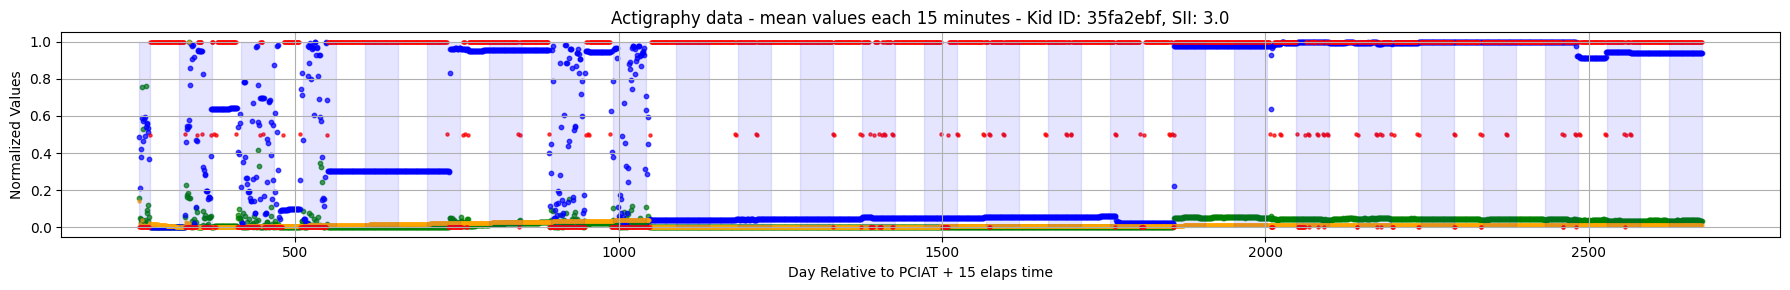

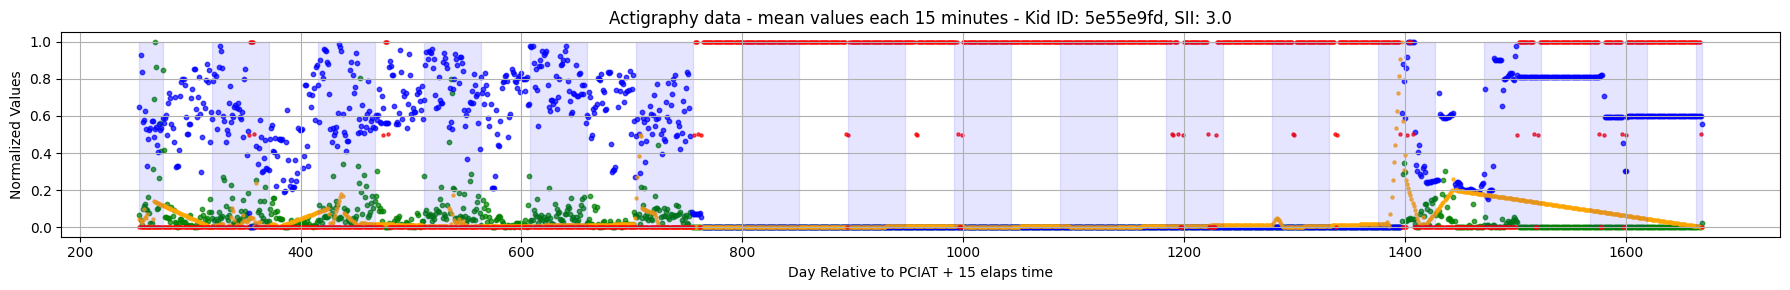

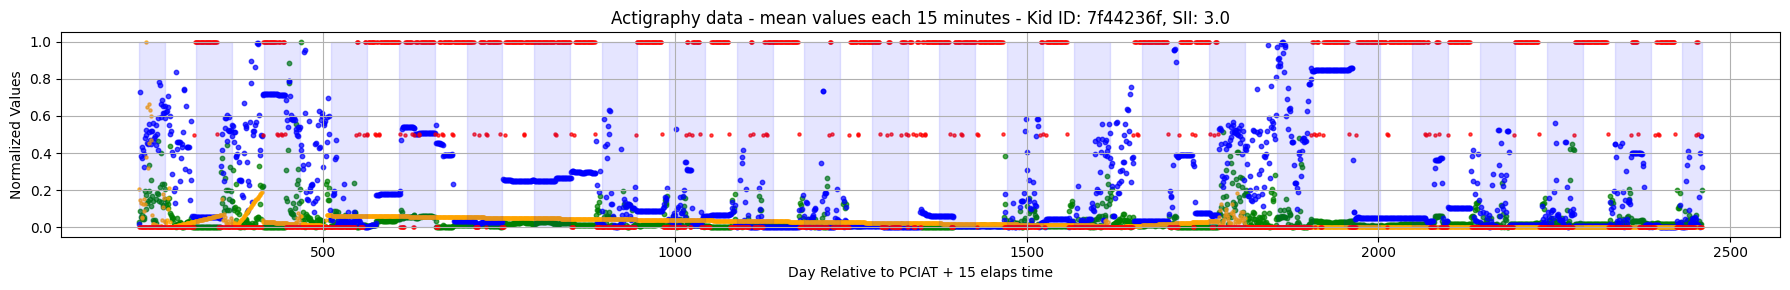

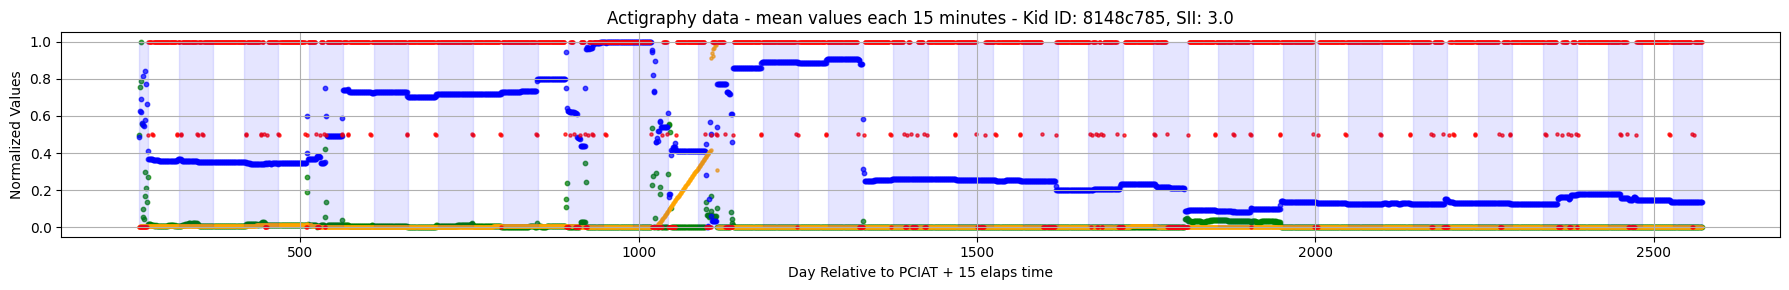

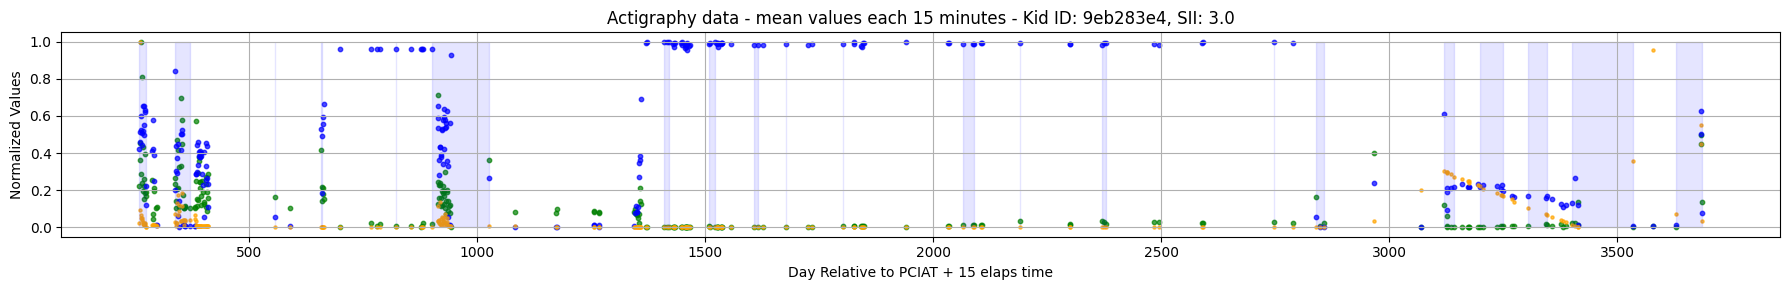

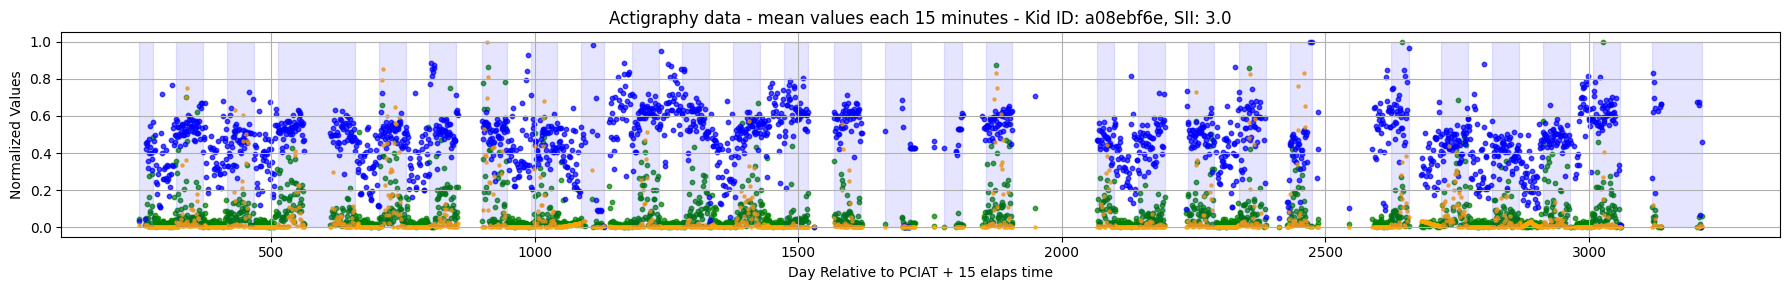

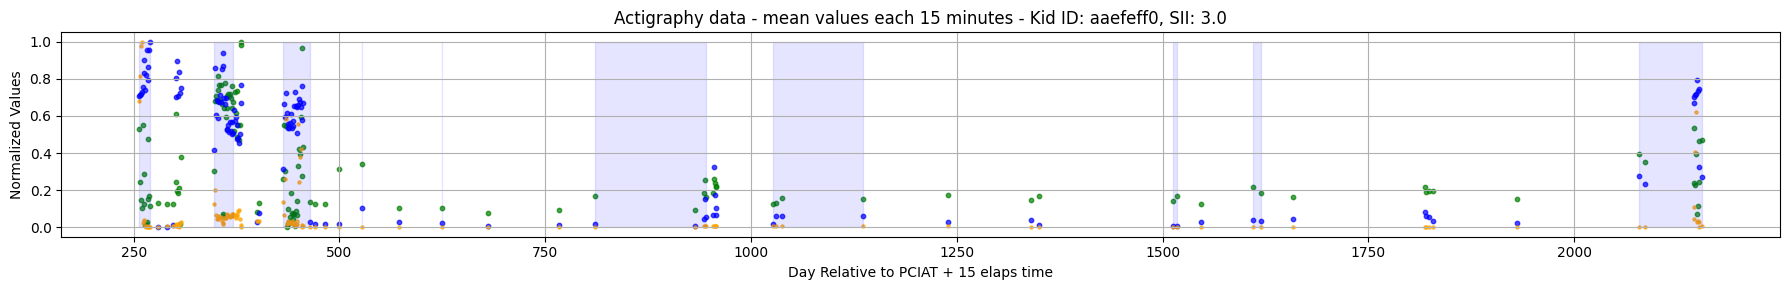

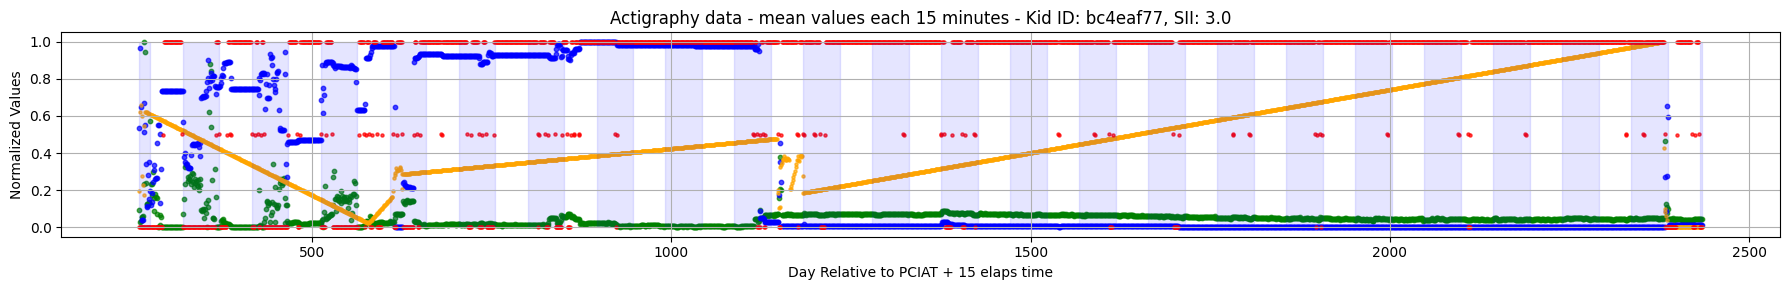

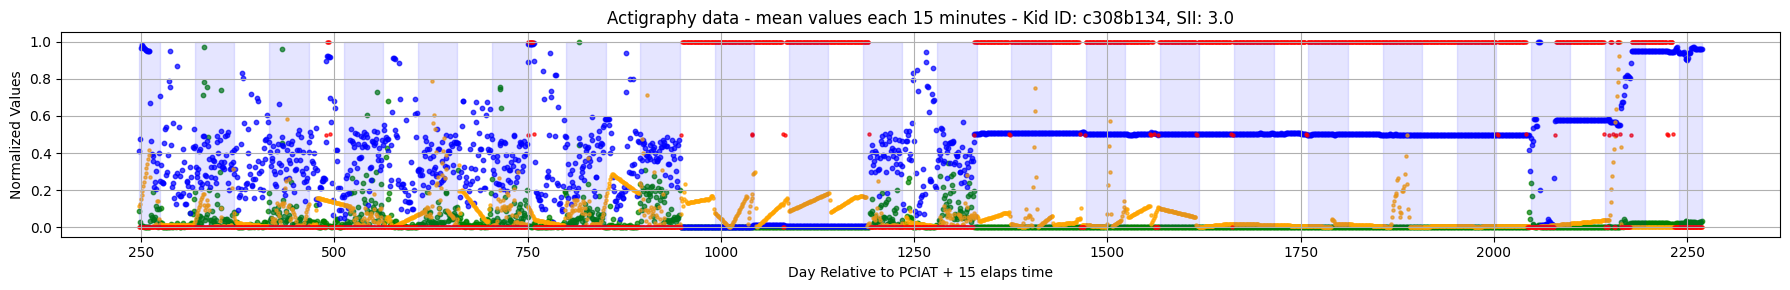

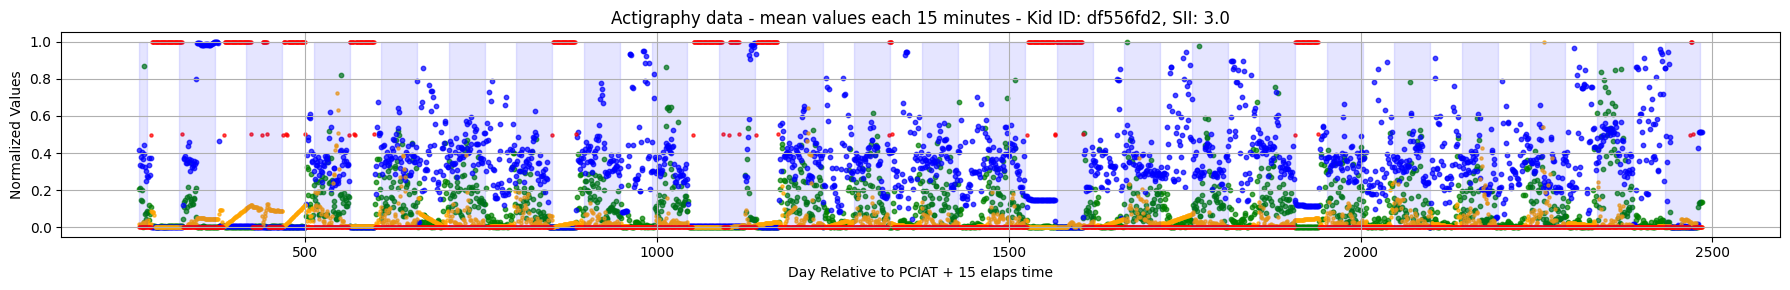

In [45]:
# Loop over the selected random IDs
for kid_id in random_ids:
    # Load the train_series for the current kid
    train_series = process_actigraphy_files(kid_id)

    df_filt = df[df['id']==kid_id]
    # Retrieve 'sii' value for the current kid from the dataframe (assuming 'sii' column exists in your df)
    sii_value = df_filt['sii'].iloc[0]  # Assuming 'sii' column exists, else adjust to get the correct value

    # Call the function to plot the data for the current kid
    plot_series_data_for_kid(kid_id, train_series, sii_value, title='Actigraphy data - mean values each 15 minutes', x_label='Day Relative to PCIAT + 15 elaps time')

In [46]:
list_of_kids = df[df['sii']==2]['id'].unique()
random_ids = random.sample(list(list_of_kids), 5)
random_ids

['63fc9770', '9b328d6c', '6d707ac3', '9ddb06db', '7800a084']

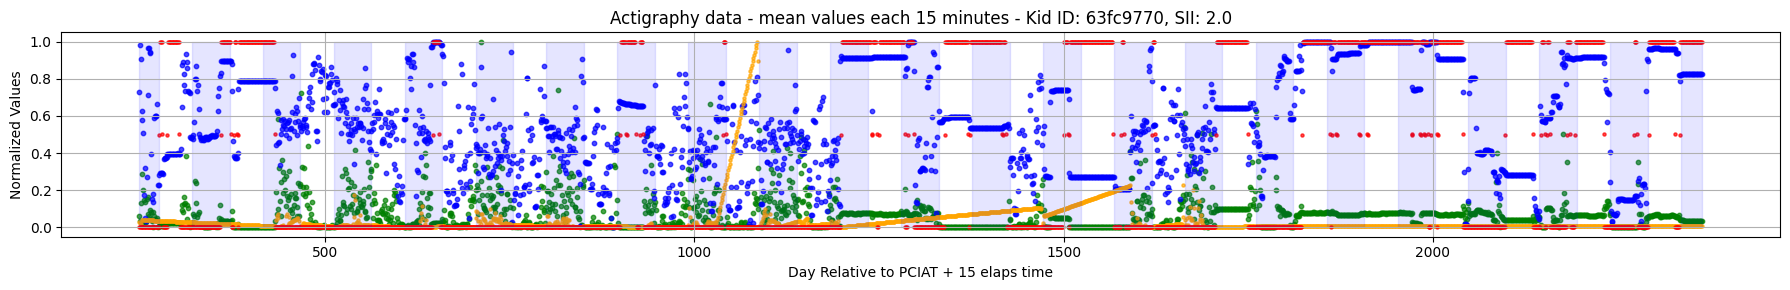

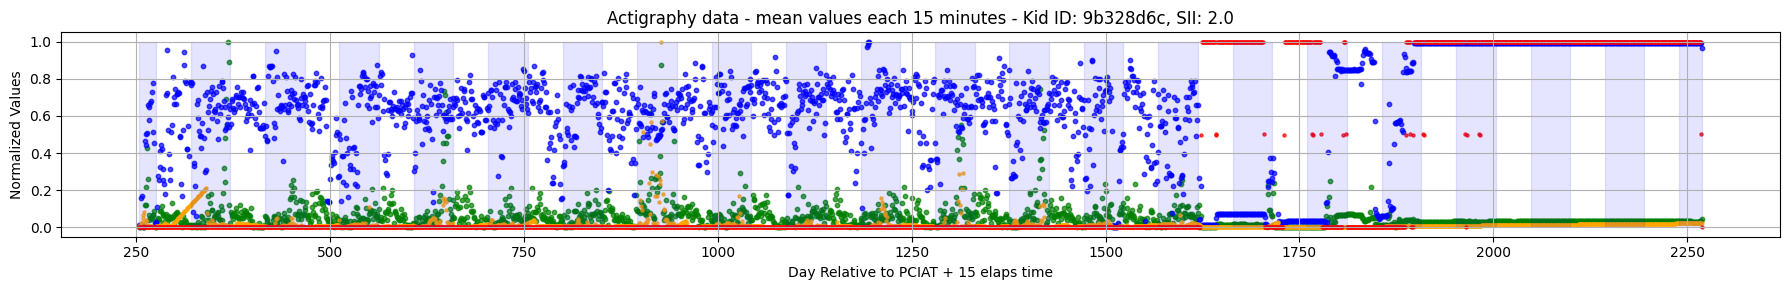

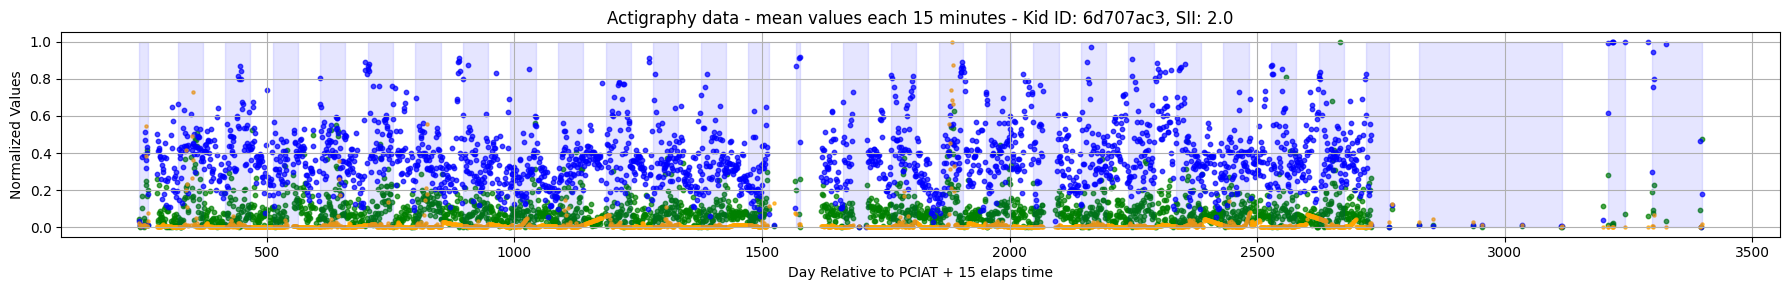

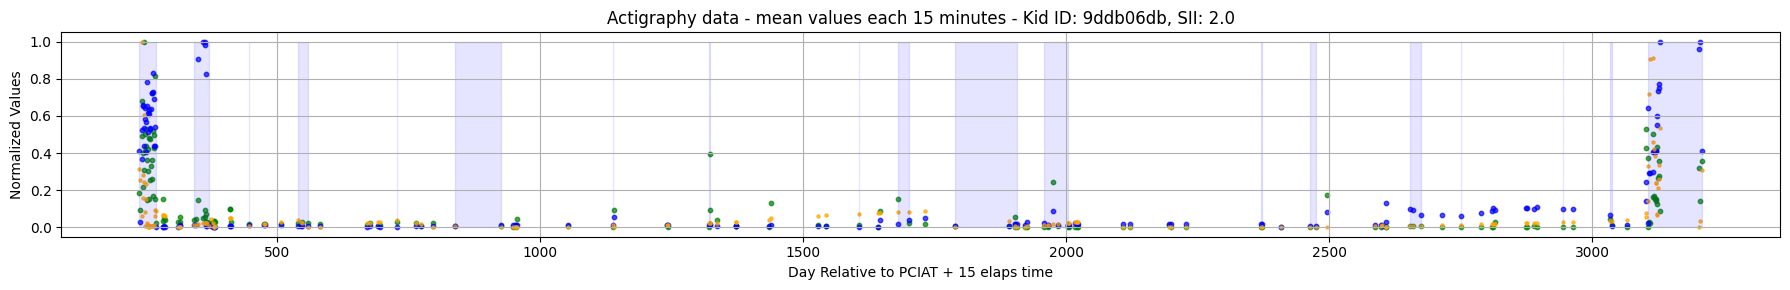

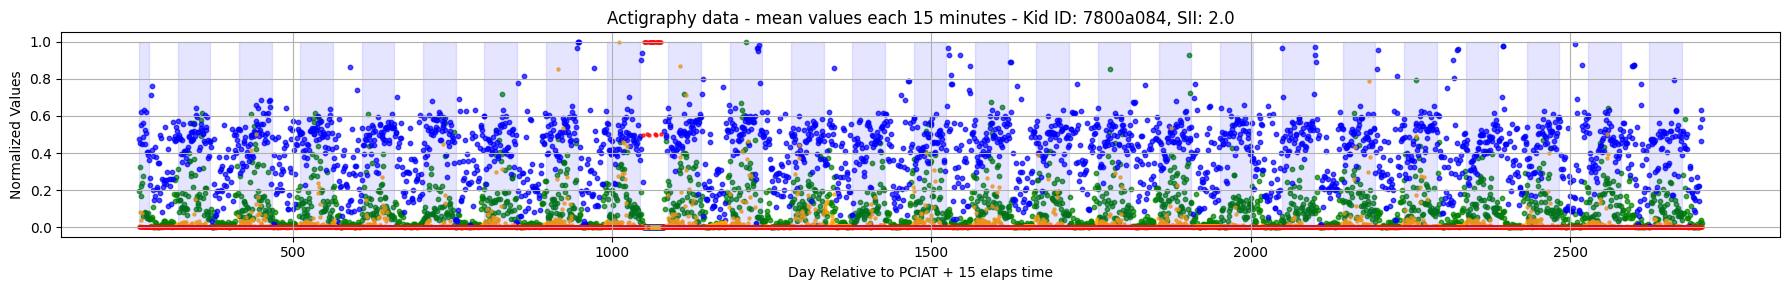

In [47]:
# Loop over the selected random IDs
for kid_id in random_ids:
    # Load the train_series for the current kid
    train_series = process_actigraphy_files(kid_id)

    df_filt = df[df['id']==kid_id]
    # Retrieve 'sii' value for the current kid from the dataframe (assuming 'sii' column exists in your df)
    sii_value = df_filt['sii'].iloc[0]  # Assuming 'sii' column exists, else adjust to get the correct value

    # Call the function to plot the data for the current kid
    plot_series_data_for_kid(kid_id, train_series, sii_value, title='Actigraphy data - mean values each 15 minutes', x_label='Day Relative to PCIAT + 15 elaps time')

In [48]:
list_of_kids = df[df['sii']==1]['id'].unique()
random_ids = random.sample(list(list_of_kids), 5)
random_ids

['9cf04c41', 'f285b43c', '0fbb3ca5', '5a313293', '8078b7de']

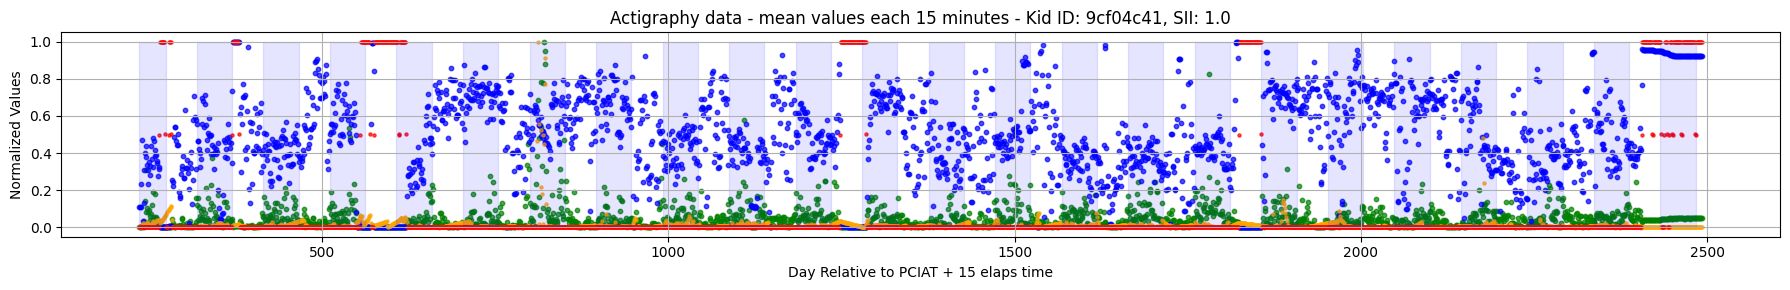

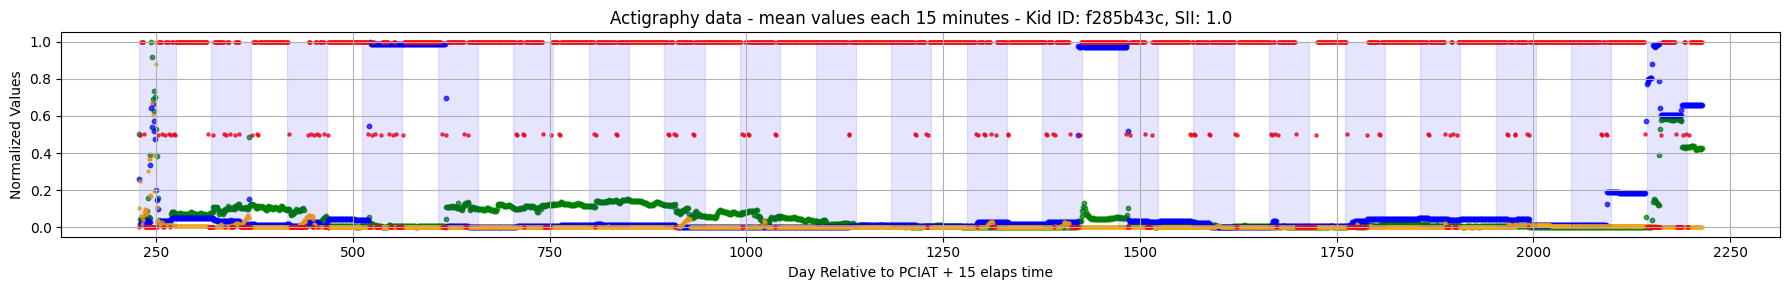

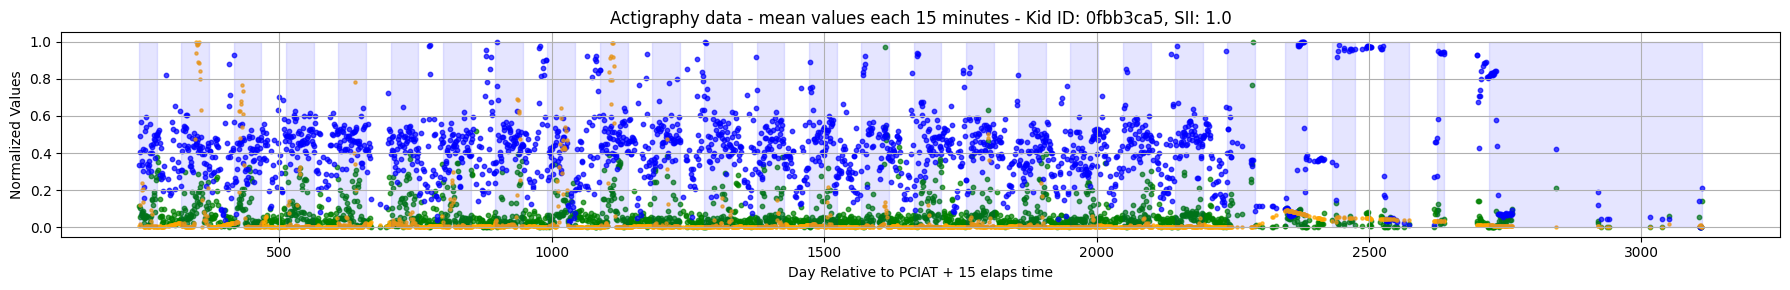

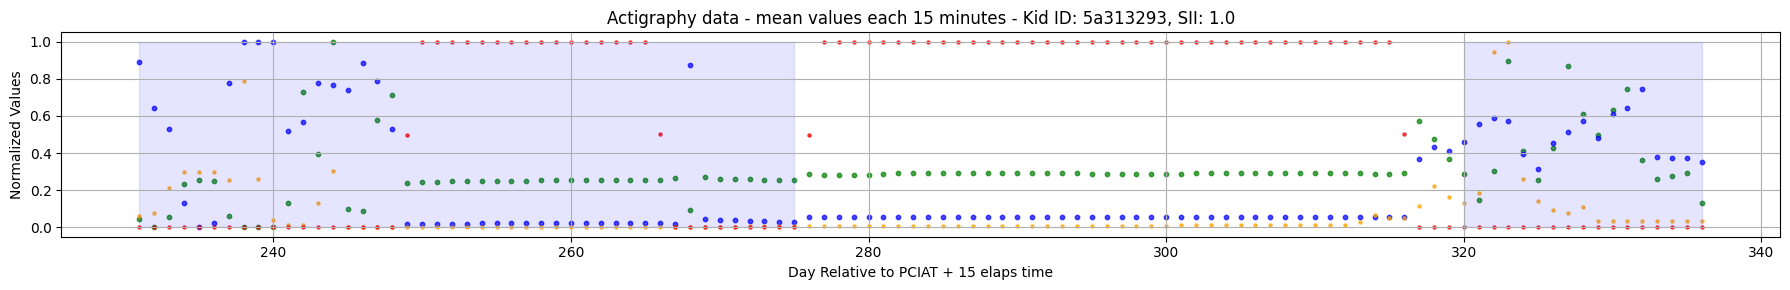

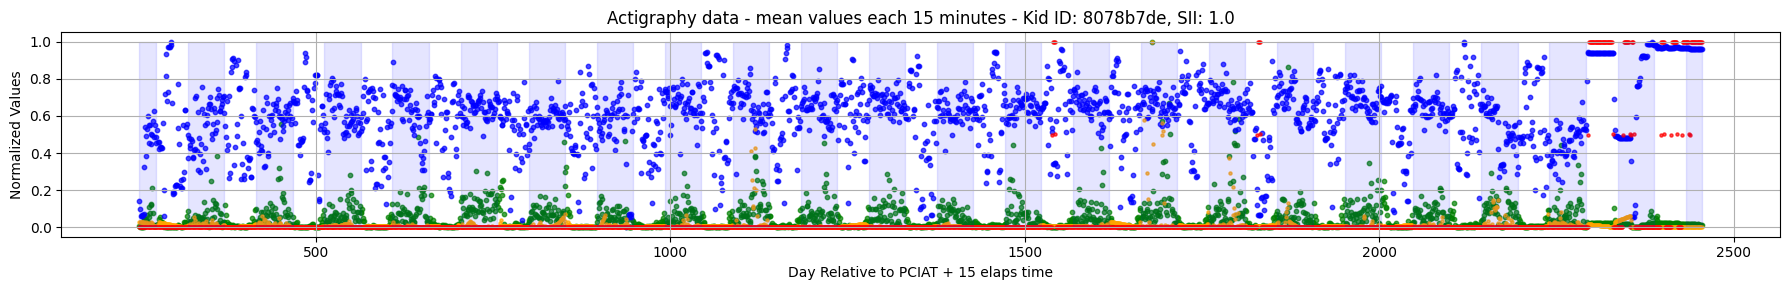

In [49]:
# Loop over the selected random IDs
for kid_id in random_ids:
    # Load the train_series for the current kid
    train_series = process_actigraphy_files(kid_id)

    df_filt = df[df['id']==kid_id]
    # Retrieve 'sii' value for the current kid from the dataframe (assuming 'sii' column exists in your df)
    sii_value = df_filt['sii'].iloc[0]  # Assuming 'sii' column exists, else adjust to get the correct value

    # Call the function to plot the data for the current kid
    plot_series_data_for_kid(kid_id, train_series, sii_value, title='Actigraphy data - mean values each 15 minutes', x_label='Day Relative to PCIAT + 15 elaps time')

# Answering some data questions.. regarding the 996 kids with actigraphy data

## lets look at '5a313293' for example -- he only use the watch for two days...

In [50]:
train_series = process_actigraphy_files('5a313293')
train_series.head(10)

step         X         Y         Z      enmo     anglez  non-wear_flag  \
0     0 -0.018424 -0.043620 -0.975495  0.045306 -88.783401            0.0   
1     1  0.007826 -0.011328 -1.036602  0.036700 -89.220978            0.0   
2     2  0.007161 -0.011302 -1.036536  0.036630 -89.221085            0.0   
3     3 -0.506628  0.413958 -0.159544  0.065311 -13.839125            0.0   
4     4 -0.578203  0.562344  0.511432  0.023681  31.190510            0.0   
5     5 -0.274349  0.586471  0.228633  0.031609  15.890021            0.0   
6     6 -0.377995  0.694727  0.449857  0.048851  26.419430            0.0   
7     7 -0.240000  0.574857  0.464362  0.037651  31.968388            0.0   
8     8 -0.395091 -0.155247  0.516445  0.027498  36.241058            0.0   
9     9 -0.131016 -0.238594  0.809102  0.083299  65.492004            0.0   

      light  battery_voltage     time_of_day  ...  total_seconds  hour  \
0  4.500000      4134.000000  35100000000000  ...        35100.0   9.0   
1  4.582192      4132.166504  35105000000000  ...        35105.0   9.0   
2  4.664383      4130.333496  35110000000000  ...        35110.0   9.0   
3  4.746575      4128.500000  35115000000000  ...        35115.0   9.0   
4  4.828767      4126.666504  35120000000000  ...        35120.0   9.0   
5  4.910959      4124.833496  35125000000000  ...        35125.0   9.0   
6  4.993151      4123.000000  35130000000000  ...        35130.0   9.0   
7  5.075343      4121.166504  35135000000000  ...        35135.0   9.0   
8  5.157534      4119.333496  35140000000000  ...        35140.0   9.0   
9  5.239726      4117.500000  35145000000000  ...        35145.0   9.0   

   minute  second  time_of_day_hours  time_of_day_half_hours  day_time  \
0    45.0     0.0           9.750000               39.000000  0.406250   
1    45.0     5.0           9.751389               39.005556  0.406308   
2    45.0    10.0           9.752778               39.011111  0.406366   
3    45.0    15.0           9.754167               39.016667  0.406424   
4    45.0    20.0           9.755556               39.022222  0.406481   
5    45.0    25.0           9.756944               39.027778  0.406539   
6    45.0    30.0           9.758333               39.033333  0.406597   
7    45.0    35.0           9.759722               39.038889  0.406655   
8    45.0    40.0           9.761111               39.044444  0.406713   
9    45.0    45.0           9.762500               39.050000  0.406771   

   day_period  which_day  day_period_b  
0         day          2             1  
1         day          2             1  
2         day          2             1  
3         day          2             1  
4         day          2             1  
5         day          2             1  
6         day          2             1  
7         day          2             1  
8         day          2             1  
9         day          2             1  

[10 rows x 23 columns]

In [52]:
train_series.groupby('which_day').size()

which_day
2    10260
3     8820
dtype: int64

# hows the distribution of number of days the watch was used by kid.

In [55]:
def process_file(file_path, kid_id):
    data = pd.read_parquet(file_path)
    non_wear_percentage = (data['non-wear_flag'].sum() / len(data)) * 100
    worn_data = data[data['non-wear_flag'] == 0]

    return {
        'id': kid_id,
        'non_wear_percentage': non_wear_percentage,
        'enmo_stats': worn_data['enmo'].describe(),
        'anglez_stats': worn_data['anglez'].describe(),
        'light_stats': worn_data['light'].describe(),
        'battery_voltage_stats': worn_data['battery_voltage'].describe(),
        'unique_days': worn_data['relative_date_PCIAT'].nunique()
    }

results = []
for kid_id in df['id'].unique():
    file_path = os.path.join(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={kid_id}/part-0.parquet')
    result = process_file(file_path, kid_id)
    results.append(result)

In [56]:
final_results = []
for result in results:
    flat_row = {
        'id': result['id'].replace('id=', ''),
        'non_wear_percentage': result['non_wear_percentage'],
        'unique_days': result['unique_days']
    }
    
    for key, stats in result.items():
        if isinstance(stats, pd.Series):
            for stat_name, stat_value in stats.items():
                flat_row[f'{key.replace("_stats", "")}_{stat_name}'] = stat_value
    
    final_results.append(flat_row)
    
stats_df = pd.DataFrame(final_results)
stats_df

id  non_wear_percentage  unique_days  enmo_count  enmo_mean  \
0    00115b9f             0.000000           40     43330.0   0.047388   
1    001f3379            65.570793           24    129316.0   0.016461   
2    00f332d1            17.124575           24    341006.0   0.036441   
3    01085eb3             3.521038           22    357626.0   0.033677   
4    012cadd8             0.000000            7     97048.0   0.058280   
..        ...                  ...          ...         ...        ...   
991  fe9c71d8            13.725731           25    365165.0   0.045263   
992  fecc07d6            93.910089           11     20845.0   0.015427   
993  ff18b749             0.000000           23    384900.0   0.053595   
994  ffcd4dbd             2.032310           25    407099.0   0.028744   
995  ffed1dd5            59.233083           24    151204.0   0.030705   

     enmo_std  enmo_min  enmo_25%  enmo_50%  enmo_75%  ...   light_75%  \
0    0.106351       0.0  0.006432  0.023637  0.041420  ...   15.000000   
1    0.040610       0.0  0.000845  0.006559  0.015562  ...   10.533334   
2    0.113819       0.0  0.001023  0.009548  0.027902  ...   18.161591   
3    0.085257       0.0  0.000938  0.007187  0.027710  ...   18.274206   
4    0.197285       0.0  0.001604  0.010466  0.038781  ...   19.320485   
..        ...       ...       ...       ...       ...  ...         ...   
991  0.111908       0.0  0.001069  0.016409  0.038898  ...    4.750000   
992  0.050504       0.0  0.001303  0.002212  0.003349  ...  162.334457   
993  0.142568       0.0  0.001506  0.014763  0.053592  ...   18.006736   
994  0.073173       0.0  0.000607  0.008500  0.025895  ...   14.328227   
995  0.104733       0.0  0.000615  0.007283  0.015582  ...    8.730386   

       light_max  battery_voltage_count  battery_voltage_mean  \
0    2633.250000                43330.0           4053.579102   
1    2597.800049               129316.0           3984.540039   
2    2611.000000               341006.0           3874.654297   
3    2650.500000               357626.0           3866.360596   
4    2618.000000                97048.0           3974.910645   
..           ...                    ...                   ...   
991  2527.199951               365165.0           3871.371826   
992   303.701996                20845.0           3940.743652   
993  2644.250000               384900.0           3842.762451   
994  2605.750000               407099.0           3851.580078   
995  1186.599976               151204.0           3930.483887   

     battery_voltage_std  battery_voltage_min  battery_voltage_25%  \
0             112.404045          3824.000000          4028.666748   
1             153.086365          3098.166748          3947.000000   
2             151.311859          3541.000000          3755.500000   
3             148.550430          3401.000000          3747.000000   
4             119.525154          3095.000000          3940.479187   
..                   ...                  ...                  ...   
991           136.905914          3378.000000          3777.000000   
992           138.468674          3779.000000          3821.750000   
993           163.234406          3098.166748          3741.000000   
994           161.214737          3098.166748          3747.000000   
995           173.447388          3098.166748          3812.000000   

     battery_voltage_50%  battery_voltage_75%  battery_voltage_max  
0                 4070.0          4147.000000               4188.5  
1                 4000.0          4076.000000               4175.0  
2                 3841.0          3994.000000               4187.0  
3                 3835.0          3988.000000               4184.0  
4                 3994.0          4046.000000               4157.0  
..                   ...                  ...                  ...  
991               3834.5          3976.000000               4183.0  
992               3923.0          3962.416748              

In [64]:
stats_df = df[['id','sii']].merge(stats_df,on='id',how="left")
stats_df

id  sii  non_wear_percentage  unique_days  enmo_count  enmo_mean  \
0    00115b9f  1.0             0.000000           40     43330.0   0.047388   
1    001f3379  1.0            65.570793           24    129316.0   0.016461   
2    00f332d1  1.0            17.124575           24    341006.0   0.036441   
3    01085eb3  0.0             3.521038           22    357626.0   0.033677   
4    012cadd8  0.0             0.000000            7     97048.0   0.058280   
..        ...  ...                  ...          ...         ...        ...   
991  fe9c71d8  0.0            13.725731           25    365165.0   0.045263   
992  fecc07d6  0.0            93.910089           11     20845.0   0.015427   
993  ff18b749  0.0             0.000000           23    384900.0   0.053595   
994  ffcd4dbd  1.0             2.032310           25    407099.0   0.028744   
995  ffed1dd5  0.0            59.233083           24    151204.0   0.030705   

     enmo_std  enmo_min  enmo_25%  enmo_50%  ...   light_75%    light_max  \
0    0.106351       0.0  0.006432  0.023637  ...   15.000000  2633.250000   
1    0.040610       0.0  0.000845  0.006559  ...   10.533334  2597.800049   
2    0.113819       0.0  0.001023  0.009548  ...   18.161591  2611.000000   
3    0.085257       0.0  0.000938  0.007187  ...   18.274206  2650.500000   
4    0.197285       0.0  0.001604  0.010466  ...   19.320485  2618.000000   
..        ...       ...       ...       ...  ...         ...          ...   
991  0.111908       0.0  0.001069  0.016409  ...    4.750000  2527.199951   
992  0.050504       0.0  0.001303  0.002212  ...  162.334457   303.701996   
993  0.142568       0.0  0.001506  0.014763  ...   18.006736  2644.250000   
994  0.073173       0.0  0.000607  0.008500  ...   14.328227  2605.750000   
995  0.104733       0.0  0.000615  0.007283  ...    8.730386  1186.599976   

     battery_voltage_count  battery_voltage_mean  battery_voltage_std  \
0                  43330.0           4053.579102           112.404045   
1                 129316.0           3984.540039           153.086365   
2                 341006.0           3874.654297           151.311859   
3                 357626.0           3866.360596           148.550430   
4                  97048.0           3974.910645           119.525154   
..                     ...                   ...                  ...   
991               365165.0           3871.371826           136.905914   
992                20845.0           3940.743652           138.468674   
993               384900.0           3842.762451           163.234406   
994               407099.0           3851.580078           161.214737   
995               151204.0           3930.483887           173.447388   

     battery_voltage_min  battery_voltage_25%  battery_voltage_50%  \
0            3824.000000          4028.666748               4070.0   
1            3098.166748          3947.000000               4000.0   
2            3541.000000          3755.500000               3841.0   
3            3401.000000          3747.000000               3835.0   
4            3095.000000          3940.479187               3994.0   
..                   ...                  ...                  ...   
991          3378.000000          3777.000000               3834.5   
992          3779.000000          3821.750000               3923.0   
993          3098.166748          3741.000000               3812.0   
994          3098.166748          3747.000000               3818.0   
995          3098.166748          3812.000000               3916.0   

     battery_voltage_75%  battery_voltage_max  
0            4147.000000               4188.5  
1            4076.000000               4175.0  
2            3994.000000               4187.0  
3            3988.000000               4184.0  
4            4046.000000               4157.0  
..                   ...                  ...  
991          3976.000000               4183.0  
992          3962.416748           

In [66]:
stats_df[(stats_df['id']=='5a313293')]

id  sii  non_wear_percentage  unique_days  enmo_count  enmo_mean  \
361  5a313293  1.0            53.773585            2      8462.0     0.0387   

     enmo_std  enmo_min  enmo_25%  enmo_50%  ...  light_75%    light_max  \
361  0.061206       0.0  0.006709  0.029464  ...  17.129879  2512.600098   

     battery_voltage_count  battery_voltage_mean  battery_voltage_std  \
361                 8462.0           3736.175049           265.064972   

     battery_voltage_min  battery_voltage_25%  battery_voltage_50%  \
361          3099.333252               3542.0               3800.0   

     battery_voltage_75%  battery_voltage_max  
361          3979.458313               4134.0  

[1 rows x 36 columns]

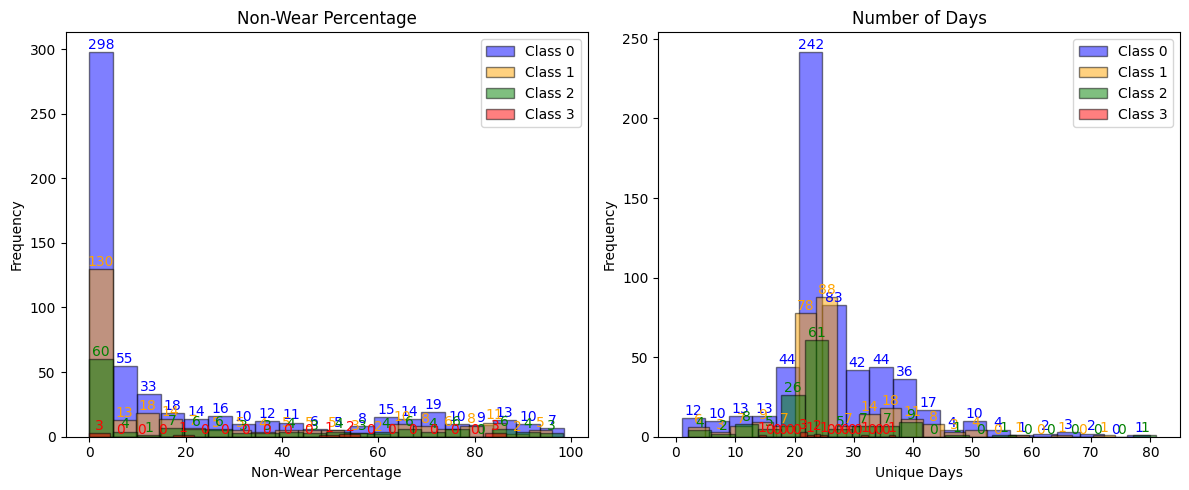

In [67]:
## Define colors for the 4 classes
class_colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}

# Create the figure for the plots
plt.figure(figsize=(12, 5))

# Non-Wear Percentage Plot
plt.subplot(1, 2, 1)

# Iterate over each unique value in 'sii' and plot the corresponding histogram
for sii_class in [0, 1, 2, 3]:
    class_data = stats_df[stats_df['sii'] == sii_class]['non_wear_percentage']
    n, bins, patches = plt.hist(class_data, bins=20, edgecolor='black', alpha=0.5, label=f'Class {sii_class}', color=class_colors[sii_class])

    # Add label to each bar with the same color as the bar
    for patch in patches:
        height = patch.get_height()
        x_position = patch.get_x() + patch.get_width() / 2
        plt.text(x_position, height + 0.05, str(int(height)), ha='center', va='bottom', fontsize=10, color=class_colors[sii_class])

# Titles and labels for Non-Wear Percentage
plt.title('Non-Wear Percentage')
plt.xlabel('Non-Wear Percentage')
plt.ylabel('Frequency')
plt.legend()

# Unique Days Plot
plt.subplot(1, 2, 2)

# Iterate over each unique value in 'sii' and plot the corresponding histogram
for sii_class in [0, 1, 2, 3]:
    class_data = stats_df[stats_df['sii'] == sii_class]['unique_days']
    n, bins, patches = plt.hist(class_data, bins=20, edgecolor='black', alpha=0.5, label=f'Class {sii_class}', color=class_colors[sii_class])

    # Add label to each bar with the same color as the bar
    for patch in patches:
        height = patch.get_height()
        x_position = patch.get_x() + patch.get_width() / 2
        plt.text(x_position, height + 0.05, str(int(height)), ha='center', va='bottom', fontsize=10, color=class_colors[sii_class])

# Titles and labels for Unique Days
plt.title('Number of Days')
plt.xlabel('Unique Days')
plt.ylabel('Frequency')
plt.legend()

# Adjust the layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

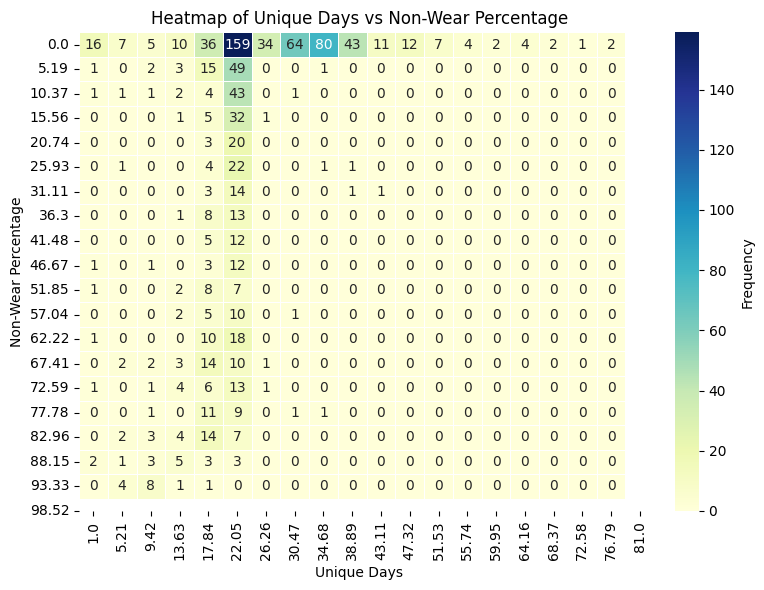

In [82]:
plt.figure(figsize=(8, 6))

# Create bins for unique days and non-wear percentage
unique_days_bins = np.linspace(stats_df['unique_days'].min(), stats_df['unique_days'].max(), 20)
non_wear_bins = np.linspace(stats_df['non_wear_percentage'].min(), stats_df['non_wear_percentage'].max(), 20)

# Create a 2D histogram (which will be used for the heatmap)
heatmap_data, xedges, yedges = np.histogram2d(
    stats_df['unique_days'], stats_df['non_wear_percentage'],
    bins=[unique_days_bins, non_wear_bins]
)

# Plot the heatmap using seaborn
sns.heatmap(
    heatmap_data.T,  # Transpose to match axes
    cmap='YlGnBu',  # Color map
    cbar_kws={'label': 'Frequency'},
    xticklabels=np.round(xedges, 2),  # X axis labels (unique days bins)
    yticklabels=np.round(yedges, 2),  # Y axis labels (non-wear percentage bins)
    annot=True,  # Annotate the heatmap with the counts
    fmt='.0f',  # Format as float (2 decimal places)
    linewidths=0.5  # Line width between cells
)

# Titles and labels
plt.title('Heatmap of Unique Days vs Non-Wear Percentage')
plt.xlabel('Unique Days')
plt.ylabel('Non-Wear Percentage')

# Display the plot
plt.tight_layout()
plt.show()

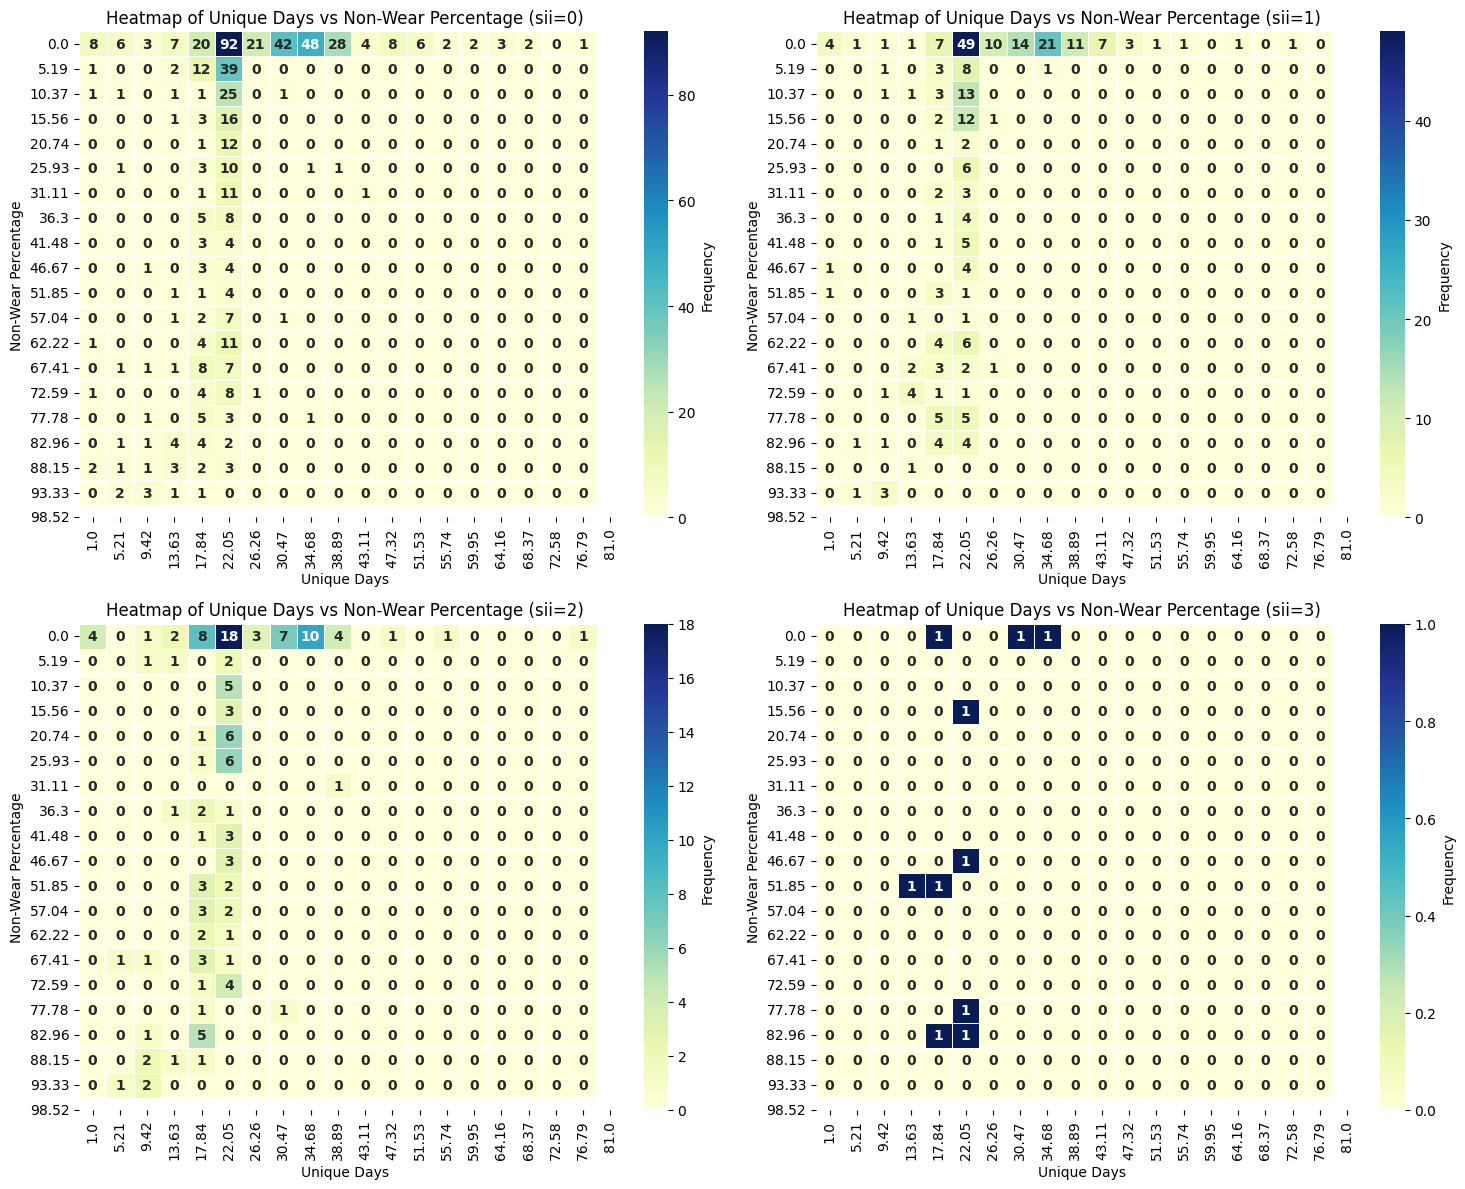

In [70]:
# Set up the figure size
plt.figure(figsize=(15, 12))

# Create bins for unique days and non-wear percentage (using the same bins for all plots)
unique_days_bins = np.linspace(stats_df['unique_days'].min(), stats_df['unique_days'].max(), 20)
non_wear_bins = np.linspace(stats_df['non_wear_percentage'].min(), stats_df['non_wear_percentage'].max(), 20)

# Loop over the sii classes (0, 1, 2, 3) to create individual heatmaps for each class
for sii_class in [0, 1, 2, 3]:
    # Filter the data for the current sii class
    class_data = stats_df[stats_df['sii'] == sii_class]
    
    # Create a 2D histogram (which will be used for the heatmap) for the current sii class
    heatmap_data, xedges, yedges = np.histogram2d(
        class_data['unique_days'], class_data['non_wear_percentage'],
        bins=[unique_days_bins, non_wear_bins]
    )
    
    # Create a subplot for each sii class
    plt.subplot(2, 2, sii_class + 1)  # 2x2 grid for 4 heatmaps

    # Plot the heatmap using seaborn
    sns.heatmap(
        heatmap_data.T,  # Transpose to match axes
        cmap='YlGnBu',  # Color map
        cbar_kws={'label': 'Frequency'},
        xticklabels=np.round(xedges, 2),  # X axis labels (unique days bins)
        yticklabels=np.round(yedges, 2),  # Y axis labels (non-wear percentage bins)
        annot=True,  # Annotate the heatmap with the counts
        fmt='.0f',  # Format as integer (counts)
        linewidths=0.5,  # Line width between cells
        annot_kws={'size': 10, 'weight': 'bold'}  # Adjust text properties
    )

    # Set the title for the current class heatmap
    plt.title(f'Heatmap of Unique Days vs Non-Wear Percentage (sii={sii_class})')
    plt.xlabel('Unique Days')
    plt.ylabel('Non-Wear Percentage')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

# how is the average - min - max changing for certain metrics, and certain targets

## for example the enmo?, the average value how much it changes in the different classes...

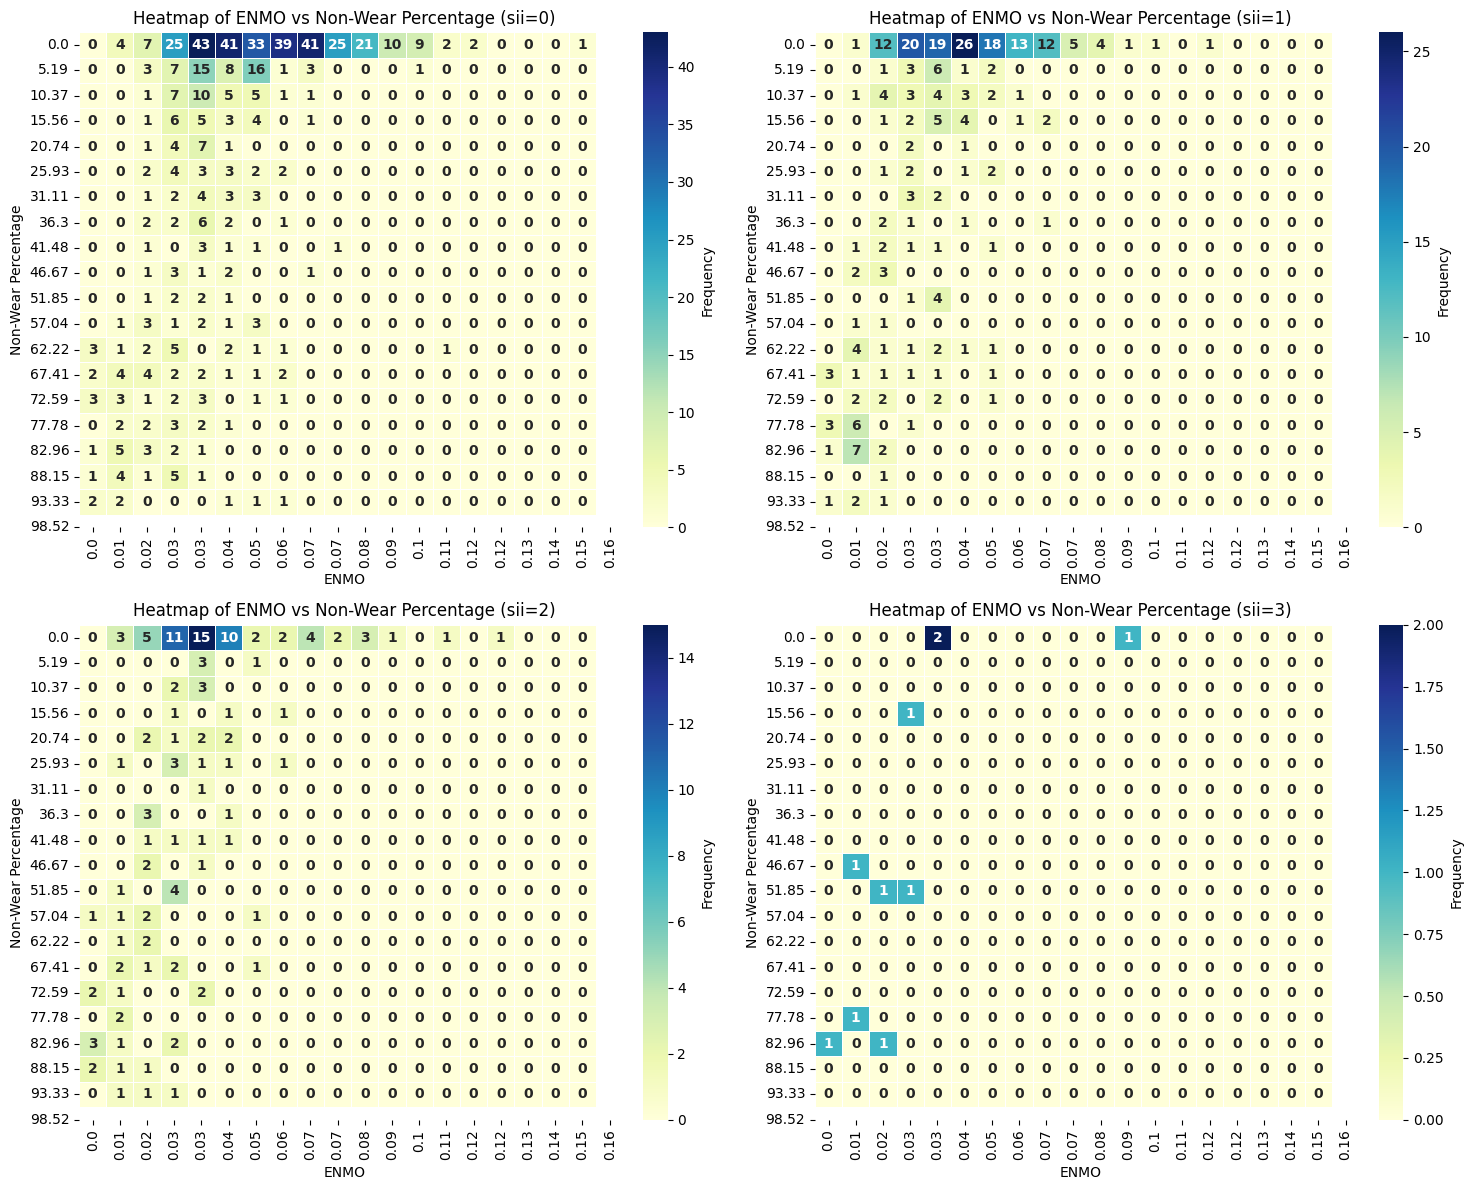

In [71]:
# Set up the figure size
plt.figure(figsize=(15, 12))

# Create bins for unique days and non-wear percentage (using the same bins for all plots)
unique_days_bins = np.linspace(stats_df['enmo_mean'].min(), stats_df['enmo_mean'].max(), 20)
non_wear_bins = np.linspace(stats_df['non_wear_percentage'].min(), stats_df['non_wear_percentage'].max(), 20)

# Loop over the sii classes (0, 1, 2, 3) to create individual heatmaps for each class
for sii_class in [0, 1, 2, 3]:
    # Filter the data for the current sii class
    class_data = stats_df[stats_df['sii'] == sii_class]
    
    # Create a 2D histogram (which will be used for the heatmap) for the current sii class
    heatmap_data, xedges, yedges = np.histogram2d(
        class_data['enmo_mean'], class_data['non_wear_percentage'],
        bins=[unique_days_bins, non_wear_bins]
    )
    
    # Create a subplot for each sii class
    plt.subplot(2, 2, sii_class + 1)  # 2x2 grid for 4 heatmaps

    # Plot the heatmap using seaborn
    sns.heatmap(
        heatmap_data.T,  # Transpose to match axes
        cmap='YlGnBu',  # Color map
        cbar_kws={'label': 'Frequency'},
        xticklabels=np.round(xedges, 2),  # X axis labels (unique days bins)
        yticklabels=np.round(yedges, 2),  # Y axis labels (non-wear percentage bins)
        annot=True,  # Annotate the heatmap with the counts
        fmt='.0f',  # Format as integer (counts)
        linewidths=0.5,  # Line width between cells
        annot_kws={'size': 10, 'weight': 'bold'}  # Adjust text properties
    )

    # Set the title for the current class heatmap
    plt.title(f'Heatmap of ENMO vs Non-Wear Percentage (sii={sii_class})')
    plt.xlabel('ENMO')
    plt.ylabel('Non-Wear Percentage')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

In [75]:
stats_df.columns

Index(['id', 'sii', 'non_wear_percentage', 'unique_days', 'enmo_count',
       'enmo_mean', 'enmo_std', 'enmo_min', 'enmo_25%', 'enmo_50%', 'enmo_75%',
       'enmo_max', 'anglez_count', 'anglez_mean', 'anglez_std', 'anglez_min',
       'anglez_25%', 'anglez_50%', 'anglez_75%', 'anglez_max', 'light_count',
       'light_mean', 'light_std', 'light_min', 'light_25%', 'light_50%',
       'light_75%', 'light_max', 'battery_voltage_count',
       'battery_voltage_mean', 'battery_voltage_std', 'battery_voltage_min',
       'battery_voltage_25%', 'battery_voltage_50%', 'battery_voltage_75%',
       'battery_voltage_max'],
      dtype='object')

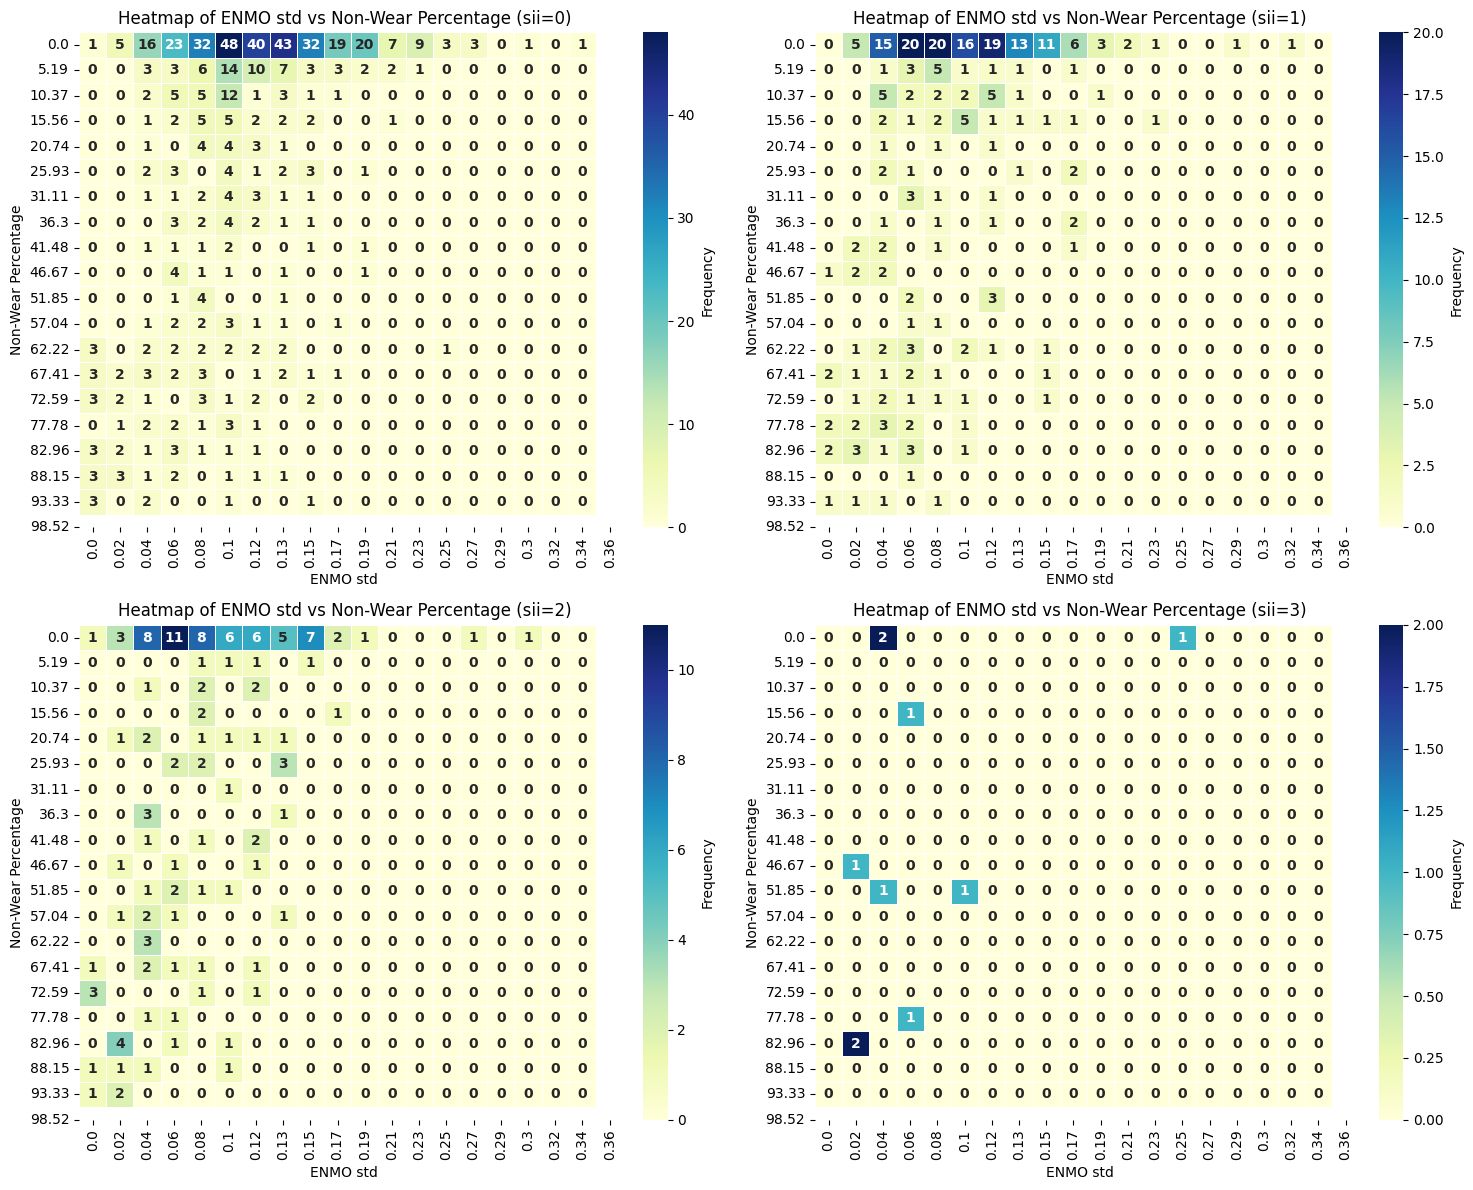

In [76]:
# Set up the figure size
plt.figure(figsize=(15, 12))

# Create bins for unique days and non-wear percentage (using the same bins for all plots)
unique_days_bins = np.linspace(stats_df['enmo_std'].min(), stats_df['enmo_std'].max(), 20)
non_wear_bins = np.linspace(stats_df['non_wear_percentage'].min(), stats_df['non_wear_percentage'].max(), 20)

# Loop over the sii classes (0, 1, 2, 3) to create individual heatmaps for each class
for sii_class in [0, 1, 2, 3]:
    # Filter the data for the current sii class
    class_data = stats_df[stats_df['sii'] == sii_class]
    
    # Create a 2D histogram (which will be used for the heatmap) for the current sii class
    heatmap_data, xedges, yedges = np.histogram2d(
        class_data['enmo_std'], class_data['non_wear_percentage'],
        bins=[unique_days_bins, non_wear_bins]
    )
    
    # Create a subplot for each sii class
    plt.subplot(2, 2, sii_class + 1)  # 2x2 grid for 4 heatmaps

    # Plot the heatmap using seaborn
    sns.heatmap(
        heatmap_data.T,  # Transpose to match axes
        cmap='YlGnBu',  # Color map
        cbar_kws={'label': 'Frequency'},
        xticklabels=np.round(xedges, 2),  # X axis labels (unique days bins)
        yticklabels=np.round(yedges, 2),  # Y axis labels (non-wear percentage bins)
        annot=True,  # Annotate the heatmap with the counts
        fmt='.0f',  # Format as integer (counts)
        linewidths=0.5,  # Line width between cells
        annot_kws={'size': 10, 'weight': 'bold'}  # Adjust text properties
    )

    # Set the title for the current class heatmap
    plt.title(f'Heatmap of ENMO std vs Non-Wear Percentage (sii={sii_class})')
    plt.xlabel('ENMO std')
    plt.ylabel('Non-Wear Percentage')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

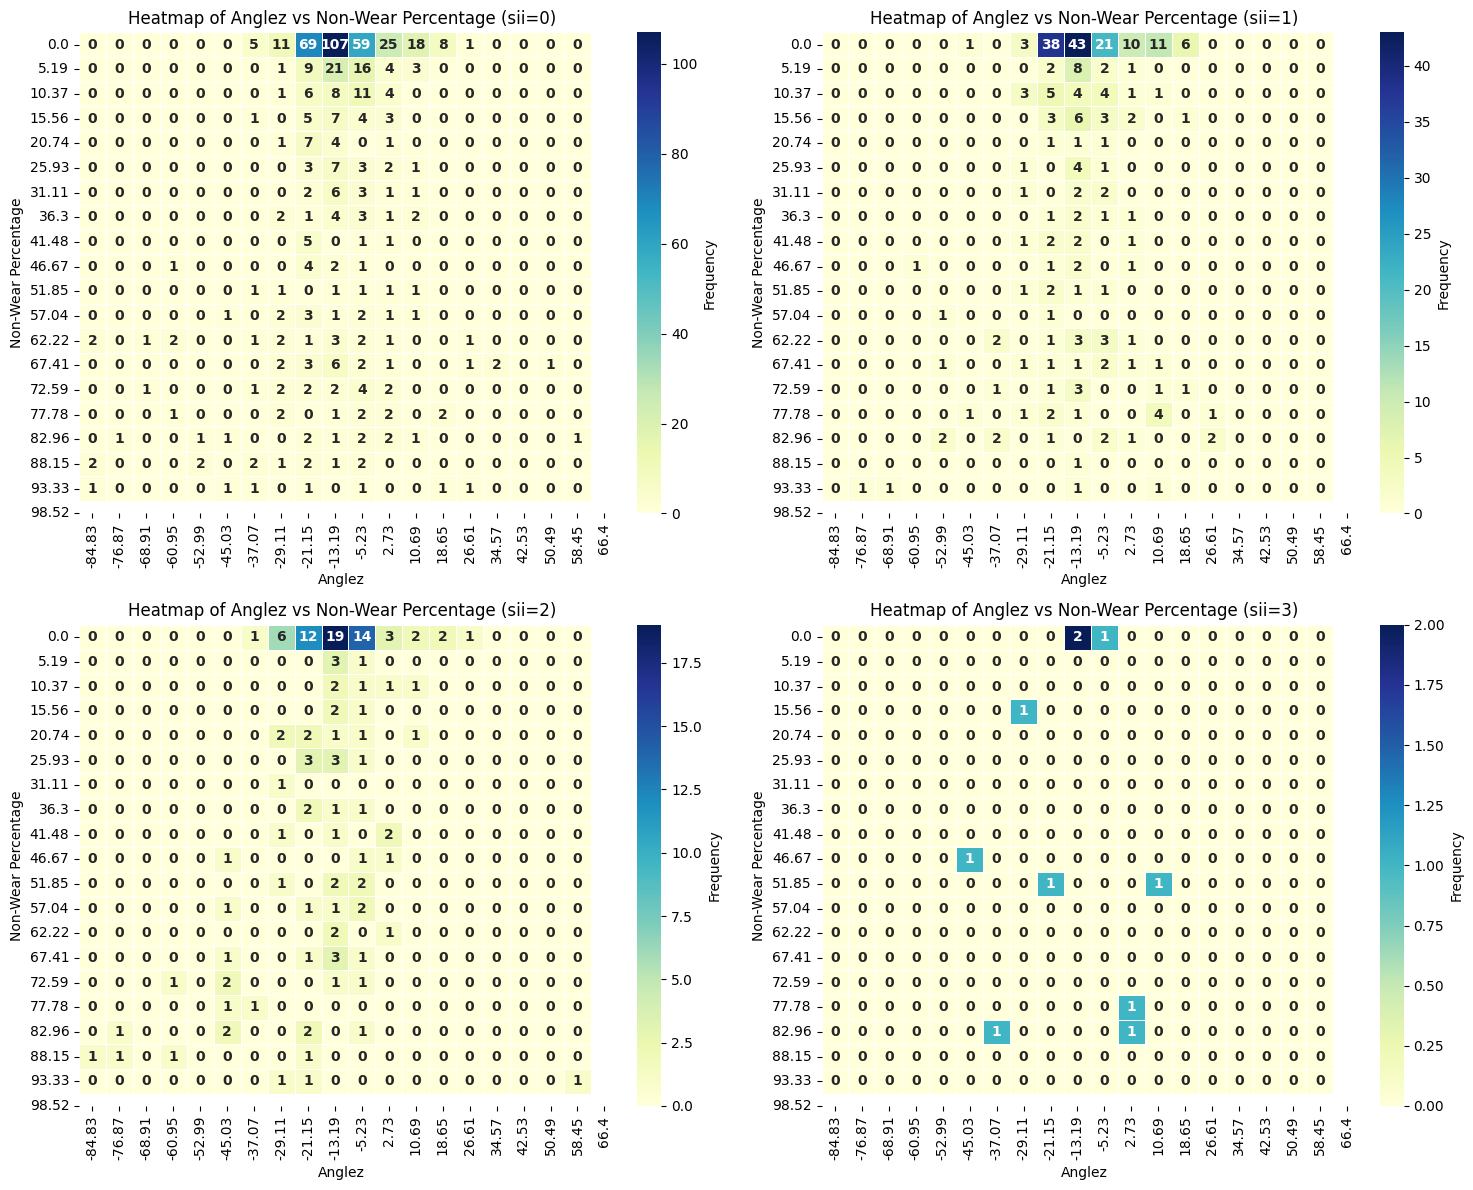

In [73]:
# Set up the figure size
plt.figure(figsize=(15, 12))

# Create bins for unique days and non-wear percentage (using the same bins for all plots)
unique_days_bins = np.linspace(stats_df['anglez_mean'].min(), stats_df['anglez_mean'].max(), 20)
non_wear_bins = np.linspace(stats_df['non_wear_percentage'].min(), stats_df['non_wear_percentage'].max(), 20)

# Loop over the sii classes (0, 1, 2, 3) to create individual heatmaps for each class
for sii_class in [0, 1, 2, 3]:
    # Filter the data for the current sii class
    class_data = stats_df[stats_df['sii'] == sii_class]
    
    # Create a 2D histogram (which will be used for the heatmap) for the current sii class
    heatmap_data, xedges, yedges = np.histogram2d(
        class_data['anglez_mean'], class_data['non_wear_percentage'],
        bins=[unique_days_bins, non_wear_bins]
    )
    
    # Create a subplot for each sii class
    plt.subplot(2, 2, sii_class + 1)  # 2x2 grid for 4 heatmaps

    # Plot the heatmap using seaborn
    sns.heatmap(
        heatmap_data.T,  # Transpose to match axes
        cmap='YlGnBu',  # Color map
        cbar_kws={'label': 'Frequency'},
        xticklabels=np.round(xedges, 2),  # X axis labels (unique days bins)
        yticklabels=np.round(yedges, 2),  # Y axis labels (non-wear percentage bins)
        annot=True,  # Annotate the heatmap with the counts
        fmt='.0f',  # Format as integer (counts)
        linewidths=0.5,  # Line width between cells
        annot_kws={'size': 10, 'weight': 'bold'}  # Adjust text properties
    )

    # Set the title for the current class heatmap
    plt.title(f'Heatmap of Anglez vs Non-Wear Percentage (sii={sii_class})')
    plt.xlabel('Anglez')
    plt.ylabel('Non-Wear Percentage')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

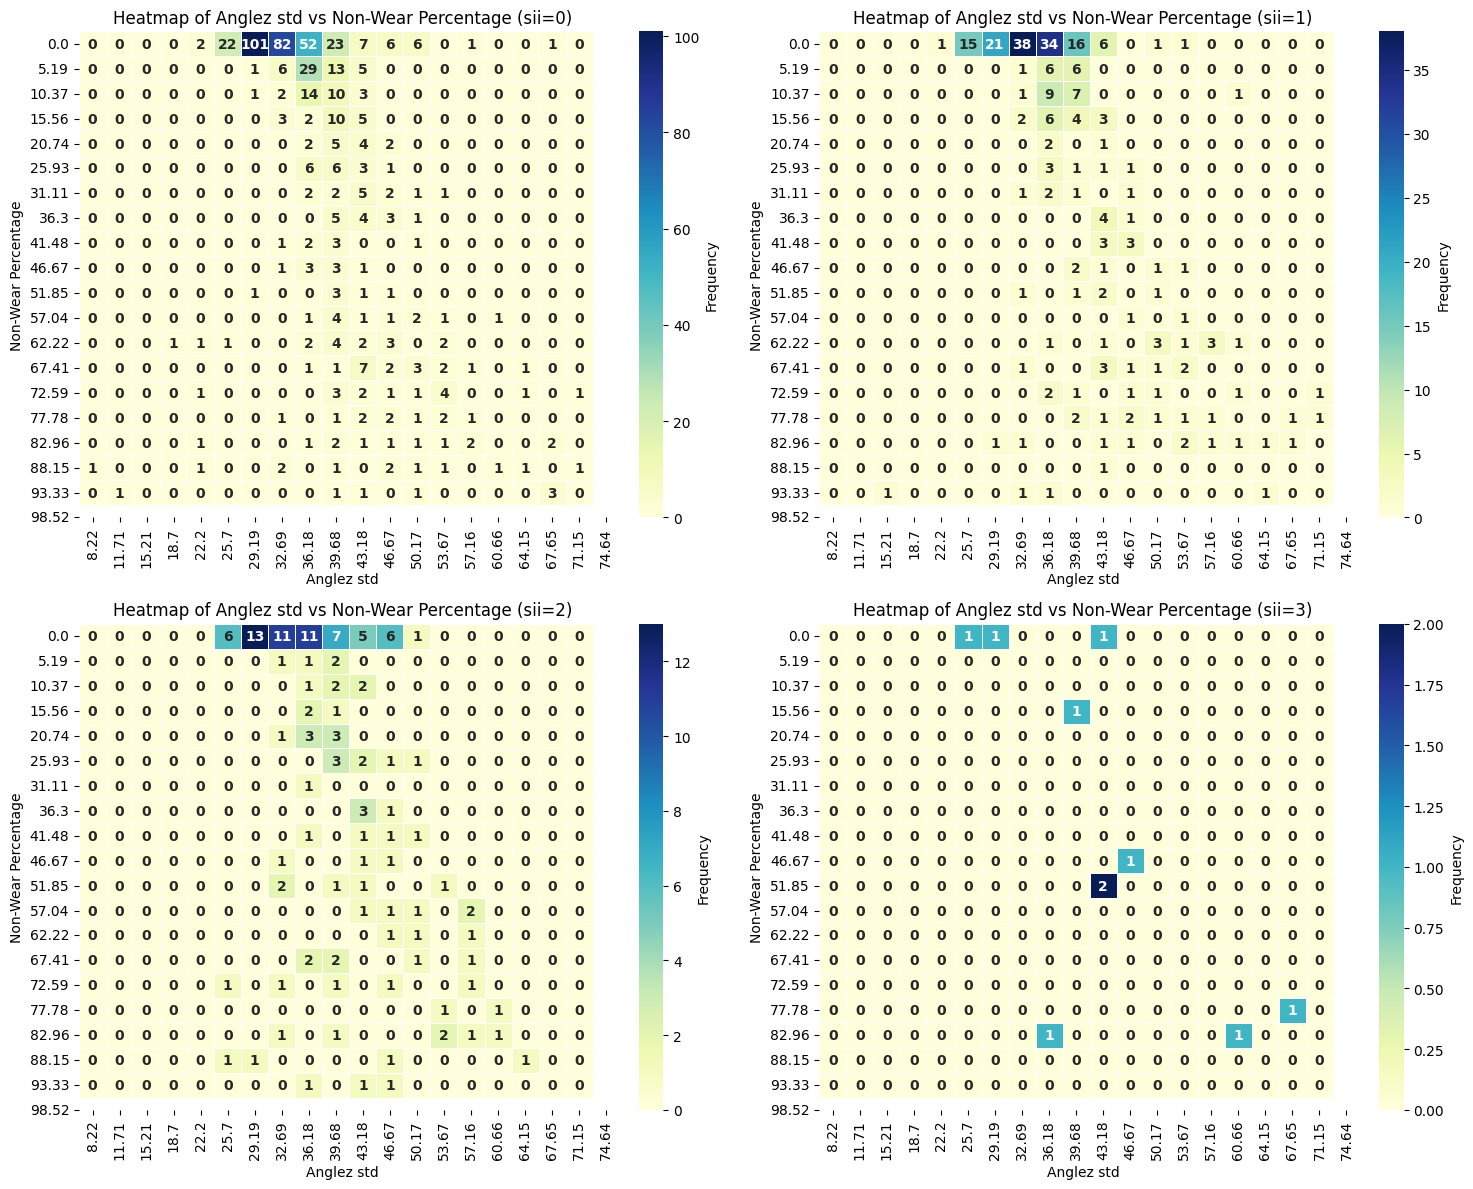

In [77]:
# Set up the figure size
plt.figure(figsize=(15, 12))

# Create bins for unique days and non-wear percentage (using the same bins for all plots)
unique_days_bins = np.linspace(stats_df['anglez_std'].min(), stats_df['anglez_std'].max(), 20)
non_wear_bins = np.linspace(stats_df['non_wear_percentage'].min(), stats_df['non_wear_percentage'].max(), 20)

# Loop over the sii classes (0, 1, 2, 3) to create individual heatmaps for each class
for sii_class in [0, 1, 2, 3]:
    # Filter the data for the current sii class
    class_data = stats_df[stats_df['sii'] == sii_class]
    
    # Create a 2D histogram (which will be used for the heatmap) for the current sii class
    heatmap_data, xedges, yedges = np.histogram2d(
        class_data['anglez_std'], class_data['non_wear_percentage'],
        bins=[unique_days_bins, non_wear_bins]
    )
    
    # Create a subplot for each sii class
    plt.subplot(2, 2, sii_class + 1)  # 2x2 grid for 4 heatmaps

    # Plot the heatmap using seaborn
    sns.heatmap(
        heatmap_data.T,  # Transpose to match axes
        cmap='YlGnBu',  # Color map
        cbar_kws={'label': 'Frequency'},
        xticklabels=np.round(xedges, 2),  # X axis labels (unique days bins)
        yticklabels=np.round(yedges, 2),  # Y axis labels (non-wear percentage bins)
        annot=True,  # Annotate the heatmap with the counts
        fmt='.0f',  # Format as integer (counts)
        linewidths=0.5,  # Line width between cells
        annot_kws={'size': 10, 'weight': 'bold'}  # Adjust text properties
    )

    # Set the title for the current class heatmap
    plt.title(f'Heatmap of Anglez std vs Non-Wear Percentage (sii={sii_class})')
    plt.xlabel('Anglez std')
    plt.ylabel('Non-Wear Percentage')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

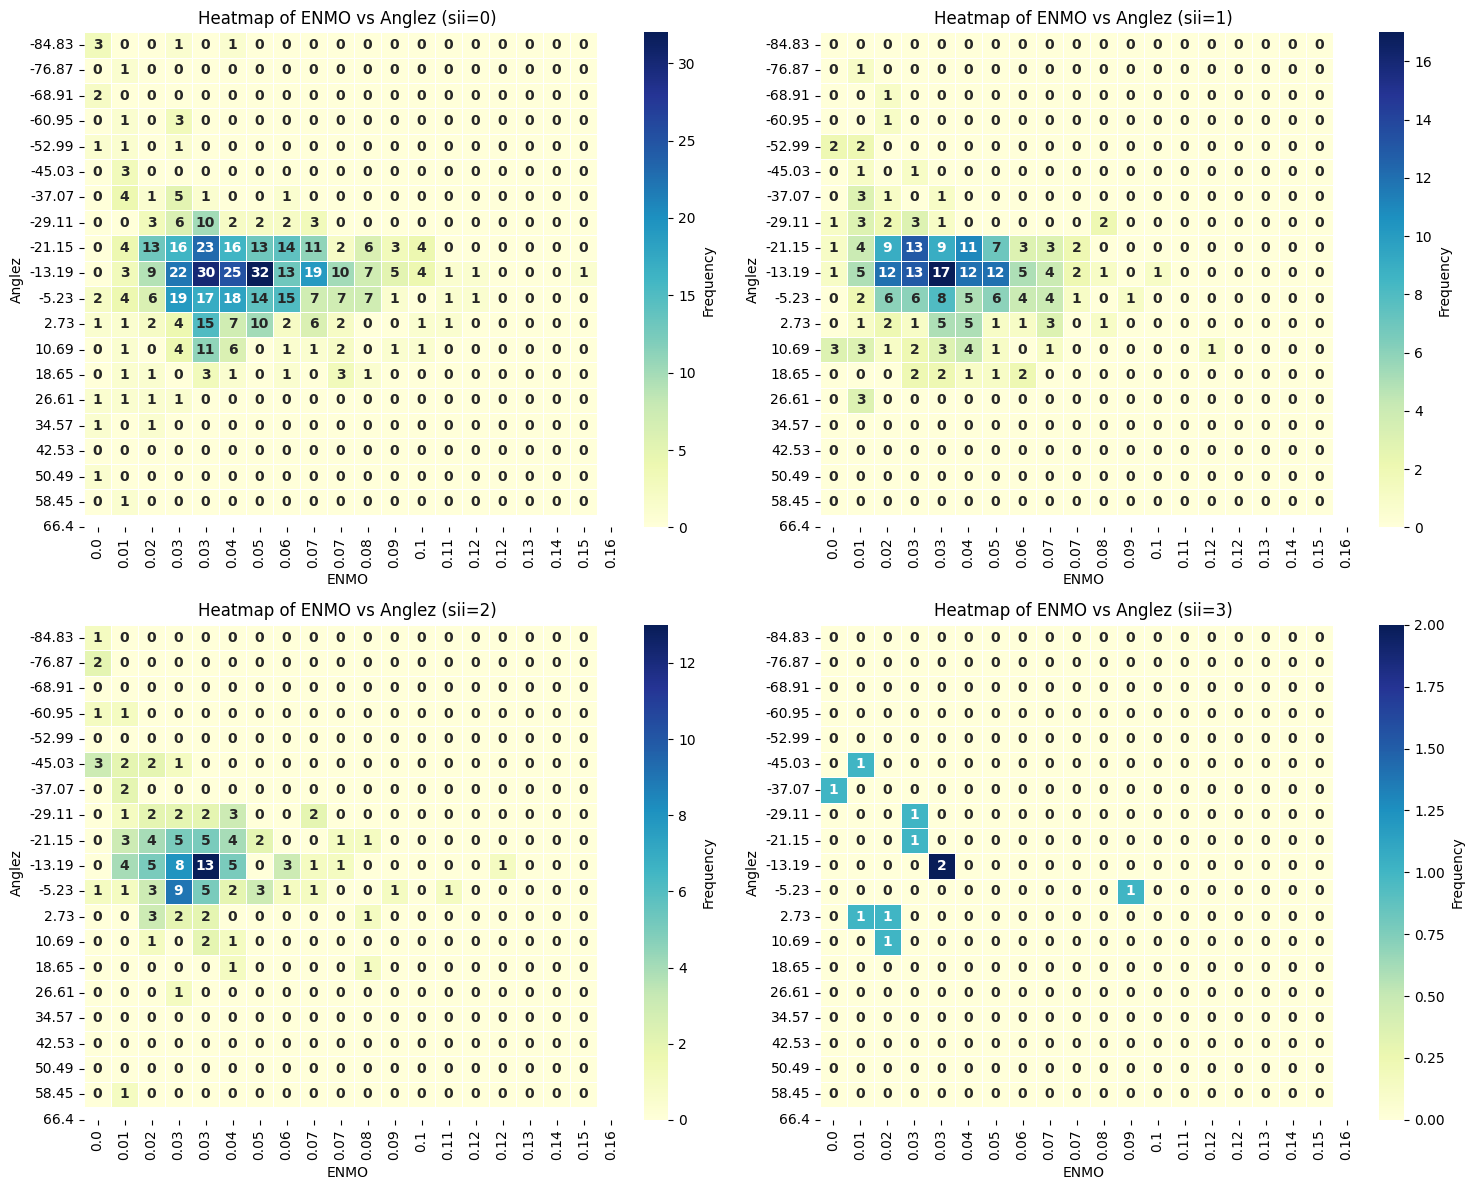

In [74]:
# Set up the figure size
plt.figure(figsize=(15, 12))

# Create bins for unique days and non-wear percentage (using the same bins for all plots)
unique_days_bins = np.linspace(stats_df['enmo_mean'].min(), stats_df['enmo_mean'].max(), 20)
non_wear_bins = np.linspace(stats_df['anglez_mean'].min(), stats_df['anglez_mean'].max(), 20)

# Loop over the sii classes (0, 1, 2, 3) to create individual heatmaps for each class
for sii_class in [0, 1, 2, 3]:
    # Filter the data for the current sii class
    class_data = stats_df[stats_df['sii'] == sii_class]
    
    # Create a 2D histogram (which will be used for the heatmap) for the current sii class
    heatmap_data, xedges, yedges = np.histogram2d(
        class_data['enmo_mean'], class_data['anglez_mean'],
        bins=[unique_days_bins, non_wear_bins]
    )
    
    # Create a subplot for each sii class
    plt.subplot(2, 2, sii_class + 1)  # 2x2 grid for 4 heatmaps

    # Plot the heatmap using seaborn
    sns.heatmap(
        heatmap_data.T,  # Transpose to match axes
        cmap='YlGnBu',  # Color map
        cbar_kws={'label': 'Frequency'},
        xticklabels=np.round(xedges, 2),  # X axis labels (unique days bins)
        yticklabels=np.round(yedges, 2),  # Y axis labels (non-wear percentage bins)
        annot=True,  # Annotate the heatmap with the counts
        fmt='.0f',  # Format as integer (counts)
        linewidths=0.5,  # Line width between cells
        annot_kws={'size': 10, 'weight': 'bold'}  # Adjust text properties
    )

    # Set the title for the current class heatmap
    plt.title(f'Heatmap of ENMO vs Anglez (sii={sii_class})')
    plt.xlabel('ENMO')
    plt.ylabel('Anglez')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()